In [2]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[1.]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[1.]], requires_grad=True)
alpha:  tensor([0.4550])
gt ols coef:  [[1.0049922]]
gt ols intercept:  [0.98592526]
trunc ols coef:  [[0.5880828]]
trunc ols intercept:  [-0.14741492]


Text(0, 0.5, 'y')

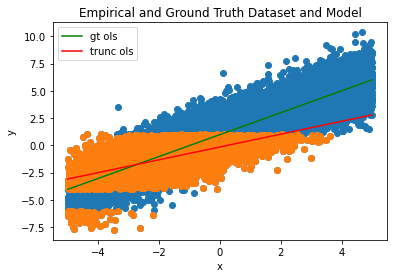

In [73]:
# distribution for generating feature vectors
d, k = 1, 1
# w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
# phi = oracle.Identity()
intervals = [(-8, -6), (-4, 1)]
phi = oracle.KIntervalUnion(intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(ch.ones(k, d))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([2.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [74]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9999)
beta:  tensor(4.9999)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on the truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.3424])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

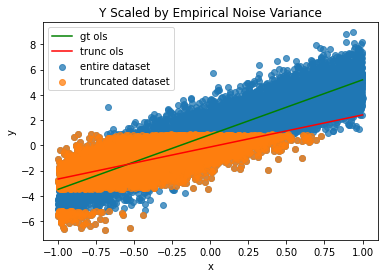

In [75]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_intervals = [(int_[0]/emp_noise_var, int_[1]/emp_noise_var) for int_ in intervals]
emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.6712])
reg noise var:  tensor([1.0127])


Text(0, 0.5, 'y')

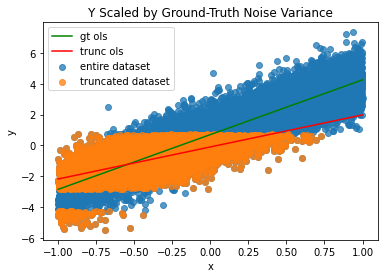

In [76]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)
stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [77]:
trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * ch.sqrt(emp_noise_var)) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * ch.sqrt(emp_noise_var))

0 steps | score: [0.24450238049030304]
100 steps | score: [0.2522695064544678]
200 steps | score: [0.14247821271419525]
300 steps | score: [0.20084036886692047]
400 steps | score: [0.29707247018814087]
500 steps | score: [0.183303564786911]
600 steps | score: [0.2556333541870117]
700 steps | score: [0.1396505981683731]
800 steps | score: [0.31877315044403076]
900 steps | score: [0.20486092567443848]
1000 steps | score: [0.1938360631465912]
1100 steps | score: [0.22274009883403778]
1200 steps | score: [0.23887240886688232]
1300 steps | score: [0.27861475944519043]


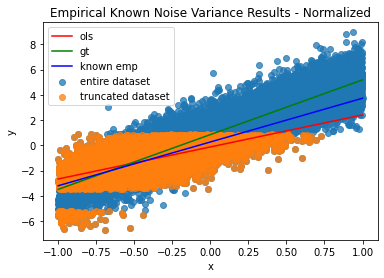

Text(0, 0.5, 'y')

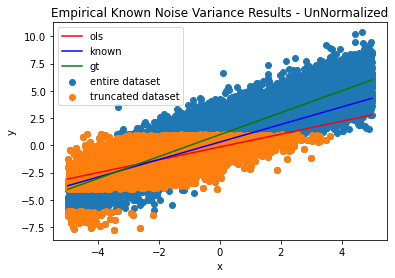

In [78]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [79]:
trunc_reg = TruncatedRegression(phi=scaled_kinterval, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=2500)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * ch.sqrt(noise_var)) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * ch.sqrt(noise_var)

0 steps | score: [-0.08650511503219604]
100 steps | score: [-0.04581739753484726]
200 steps | score: [-0.1050160601735115]
300 steps | score: [-0.09050310403108597]
400 steps | score: [0.015834834426641464]
500 steps | score: [-0.09193232655525208]
600 steps | score: [-0.012469545006752014]
700 steps | score: [-0.102044016122818]
800 steps | score: [0.012199152261018753]
900 steps | score: [-0.06101793795824051]
1000 steps | score: [-0.08049361407756805]
1100 steps | score: [-0.04175977036356926]
1200 steps | score: [-0.03605726361274719]
1300 steps | score: [0.006995882838964462]


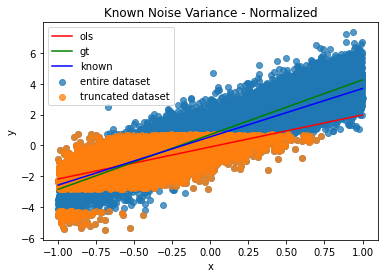

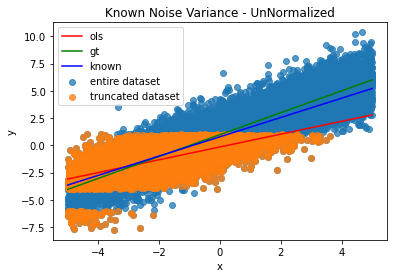

In [80]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [81]:
trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=True, bs=10, n=100, tol=1e-2, val=100, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * ch.sqrt(emp_noise_var)) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * ch.sqrt(emp_noise_var)).detach().numpy()

0 steps | score: [-0.1568070352077484, 0.08321969211101532]
100 steps | score: [-0.048823095858097076, 0.006759066134691238]
200 steps | score: [-0.3318922817707062, -0.7452709078788757]
300 steps | score: [-0.30775973200798035, -0.6020576357841492]
400 steps | score: [-0.21123218536376953, -0.4622640609741211]
500 steps | score: [-0.16567757725715637, -0.276089608669281]
600 steps | score: [-0.1283351331949234, -0.22076290845870972]
700 steps | score: [-0.2728740870952606, -0.5913558602333069]
800 steps | score: [-0.04879714176058769, -0.01451406255364418]
900 steps | score: [-0.13640156388282776, -0.2577878534793854]
1000 steps | score: [-0.1838807910680771, -0.3610472083091736]
1100 steps | score: [-0.08731968700885773, -0.0714782327413559]
1200 steps | score: [-0.021591393277049065, 0.05796915292739868]
1300 steps | score: [-0.047581370919942856, -0.06651917845010757]
1400 steps | score: [-0.17746832966804504, -0.3190794289112091]
1500 steps | score: [0.004769529215991497, 0.073676

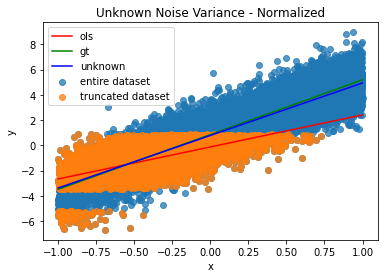

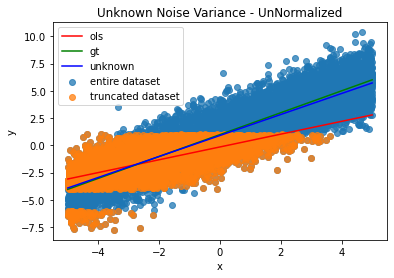

In [82]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [18]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('samples', 1000)

EXP = 'KIntervalUnionNoiseVar10.02DimsUniformFeaturesCheckGrad'

In [35]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
dist = Uniform(-100, 100)
samples = [100, 150, 200, 250, 500, 750, 1000, 1500, 2000, 2500, 5000, 10000]
intervals = [(-7, -5), (-3, 0), (3, 4)]
phi = oracle.KIntervalUnion(intervals)
noise_var = Tensor([10.0])

stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_scale': float, 
    })
    
    
    for s in samples: 
        X, noised = Tensor([]), Tensor([])
        x_trunc, y_trunc = Tensor([]), Tensor([])
        
        # generate data until s number of samples fall within the truncation set
        with ch.no_grad():
            while x_trunc.size(0) < s: 
                x_ = dist.sample(ch.Size([s, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([s]))
                new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(s, 1)
                # add noise to ground-truth pedictions
                # truncate based off of the standardized data
                indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
                y_trunc, x_trunc = ch.cat([y_trunc, new_noised[indices]]), ch.cat([x_trunc, x_[indices]])
                X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
        x_trunc, y_trunc = x_trunc[:s], y_trunc[:s]
        alpha = Tensor([y_trunc.size(0) / noised.size(0)])
        val = int(.2*s)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        trunc_reg = trunc_reg = TruncatedRegression(phi=scaled_kinterval, alpha=alpha, bias=args.bias, unknown=False, bs=args.bs, n=100, tol=args.tol, steps=args.steps, val=val)
        st = datetime.datetime.now()
        known_results = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
        w, w0 = (known_results.weight.detach().cpu() * math.sqrt(ch.ones(1))) / beta, known_results.bias.detach().cpu()[..., None] * math.sqrt(ch.ones(1))
        known_params = ch.cat([w, w0], dim=1).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # truncated regression with unknown variance
        # run procedure until get reasonable gradient value
        st = datetime.datetime.now()
        attempt, grad = 0, None
        best, unknown_results = None, None
        while (grad is None or grad < 3e-1) and attempt < 3:
            trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=args.bias, unknown=True, bs=args.bs, n=100, tol=args.tol, steps=args.steps, val=val)
            res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
            grad = ch.abs(ch.cat([res.weight.grad.flatten(), res.bias.grad.flatten(), res.lambda_.grad.flatten()])).mean(0)
            if best is None or grad < best: 
                best, unknown_results = grad, res
            attempt += 1
    
        var_ = unknown_results.lambda_.inverse()
        unknown_var = var_ * emp_noise_var
        w, w0 = (((unknown_results.weight * var_) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_results.bias * ch.sqrt(emp_noise_var))).detach()[None,...]
        unknown_params = ch.cat([w, w0], dim=1).flatten()
        
        if mse_loss(unknown_params, gt_params) > 2.0: 
            print("unknown params: ", unknown_params)
            print("gt params: ", gt_params)

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/KIntervalUnionNoiseVar10.02DimsUniformFeaturesCheckGrad/29c5c993-f91e-4f11-9d8d-f87db6673481
Iteration: 0.0 | Score: [0.030764585360884666]
Iteration: 1.0 | Score: [-0.08174990862607956]
Iteration: 2.0 | Score: [0.02568255551159382]
Iteration: 3.0 | Score: [-0.01864708587527275]
Iteration: 4.0 | Score: [-0.01767064444720745]
Iteration: 5.0 | Score: [0.01318303681910038]
Iteration: 6.0 | Score: [0.012454446405172348]
Iteration: 7.0 | Score: [-0.039172351360321045]
Iteration: 8.0 | Score: [-0.03381642699241638]
Iteration: 9.0 | Score: [-0.04364798963069916]
Iteration: 10.0 | Score: [-0.00039156293496489525]
Iteration: 0.0 | Score: [-0.24196714162826538, -0.009053736925125122]
Iteration: 1.0 | Score: [-0.22101639211177826, -0.15614663064479828]
Iteration: 2.0 | Score: [-0.23057952523231506, -0.16562998294830322]
Iteration: 3.0 | Score: [-0.14637446403503418, -0.16498777270317078]
Iteration: 4.0 | Score: [-0.18393827974796295, -0.17735758423805

Iteration: 14.0 | Score: [-0.060254521667957306, -0.03025352954864502]
Iteration: 15.0 | Score: [-0.08821751922369003, -0.02532685175538063]
Iteration: 16.0 | Score: [-0.026569372043013573, -0.03556649386882782]
Iteration: 17.0 | Score: [-0.050251882523298264, -0.04103434458374977]
Iteration: 18.0 | Score: [-0.05716344714164734, -0.04803899675607681]
Iteration: 19.0 | Score: [-0.03291187062859535, -0.06291148066520691]
Iteration: 20.0 | Score: [-0.0666627585887909, -0.05208654701709747]
Iteration: 21.0 | Score: [-0.04866699501872063, -0.03888203576207161]
Iteration: 22.0 | Score: [-0.05305078253149986, -0.05487511679530144]
Iteration: 23.0 | Score: [-0.06305692344903946, -0.09132103621959686]
Iteration: 24.0 | Score: [-0.05042169615626335, -0.05010412260890007]
Iteration: 25.0 | Score: [-0.06198694184422493, -0.02296532317996025]
Iteration: 0.0 | Score: [0.025350064039230347, 0.23020035028457642]
Iteration: 1.0 | Score: [0.04583323374390602, 0.09918560087680817]
Iteration: 2.0 | Score:

Iteration: 25.0 | Score: [-0.10529892146587372, -0.11475144326686859]
Iteration: 0.0 | Score: [-0.12302105873823166, 0.2028525173664093]
Iteration: 1.0 | Score: [-0.1145249605178833, 0.07300862669944763]
Iteration: 2.0 | Score: [-0.08332648873329163, 0.05941051244735718]
Iteration: 3.0 | Score: [-0.14233364164829254, -0.016936616972088814]
Iteration: 4.0 | Score: [-0.08962199836969376, 0.009979184716939926]
Iteration: 5.0 | Score: [-0.10521743446588516, 0.0321635976433754]
Iteration: 6.0 | Score: [-0.13408474624156952, -0.007409354671835899]
Iteration: 7.0 | Score: [-0.0784408450126648, 0.050223033875226974]
Iteration: 8.0 | Score: [-0.16668954491615295, -0.02119220793247223]
Iteration: 9.0 | Score: [-0.1507338434457779, -0.022912319749593735]
Iteration: 10.0 | Score: [-0.17181438207626343, -0.02847115881741047]
Iteration: 11.0 | Score: [-0.10319741070270538, -0.005334118381142616]
Iteration: 12.0 | Score: [-0.1266506314277649, 0.01507280021905899]
Iteration: 13.0 | Score: [-0.08618889

Iteration: 19.0 | Score: [0.1013404130935669, 0.05220414325594902]
Iteration: 20.0 | Score: [0.11877750605344772, 0.055570099502801895]
Iteration: 21.0 | Score: [0.08838021755218506, 0.03280624747276306]
Iteration: 22.0 | Score: [0.06943748891353607, 0.018270807340741158]
Iteration: 23.0 | Score: [0.11537378281354904, 0.05426541715860367]
Iteration: 24.0 | Score: [0.09665416181087494, 0.04792775958776474]
Iteration: 25.0 | Score: [0.06494975090026855, 0.027432894334197044]
Iteration: 0.0 | Score: [-0.07496194541454315, 0.09704580157995224]
Iteration: 1.0 | Score: [-0.02642679400742054, 0.029643848538398743]
Iteration: 2.0 | Score: [-0.013484243303537369, -0.0075244298204779625]
Iteration: 3.0 | Score: [-0.02146673947572708, -0.034735057502985]
Iteration: 4.0 | Score: [-0.049516864120960236, -0.024144863709807396]
Iteration: 5.0 | Score: [-0.02139289118349552, -0.03656115382909775]
Iteration: 6.0 | Score: [-0.04976492002606392, -0.08055821061134338]
Iteration: 7.0 | Score: [-0.049149636

Iteration: 1.0 | Score: [0.06386816501617432]
Iteration: 2.0 | Score: [0.07068543881177902]
Iteration: 3.0 | Score: [0.07430730760097504]
Iteration: 4.0 | Score: [0.051722560077905655]
Iteration: 5.0 | Score: [0.08235951513051987]
Iteration: 6.0 | Score: [0.07898947596549988]
Iteration: 7.0 | Score: [0.07164538651704788]
Iteration: 8.0 | Score: [0.06973779946565628]
Iteration: 9.0 | Score: [0.063653364777565]
Iteration: 10.0 | Score: [0.06163252145051956]
Iteration: 11.0 | Score: [0.08755860477685928]
Iteration: 12.0 | Score: [0.07184604555368423]
Iteration: 13.0 | Score: [0.08155927062034607]
Iteration: 14.0 | Score: [0.0802324190735817]
Iteration: 15.0 | Score: [0.08234530687332153]
Iteration: 16.0 | Score: [0.07751765102148056]
Iteration: 17.0 | Score: [0.06419070810079575]
Iteration: 18.0 | Score: [0.07833286374807358]
Iteration: 19.0 | Score: [0.08575242012739182]
Iteration: 20.0 | Score: [0.08645300567150116]
Iteration: 21.0 | Score: [0.08199170231819153]
Iteration: 22.0 | Score:

Iteration: 15.0 | Score: [-0.01442128885537386, -0.022245503962039948]
Iteration: 16.0 | Score: [-0.0062276148237288, -0.02652842551469803]
Iteration: 17.0 | Score: [-0.00417676055803895, -0.02944554015994072]
Iteration: 18.0 | Score: [-0.015515134669840336, -0.04234921559691429]
Iteration: 19.0 | Score: [-0.023052969947457314, -0.0439218208193779]
Iteration: 20.0 | Score: [-0.014486335217952728, -0.042797282338142395]
Iteration: 21.0 | Score: [-0.008269577287137508, -0.021487172693014145]
Iteration: 22.0 | Score: [-0.016405124217271805, -0.03093007393181324]
Iteration: 23.0 | Score: [-0.004819189198315144, -0.03795754536986351]
Iteration: 24.0 | Score: [-0.015469285659492016, -0.026479283347725868]
Iteration: 25.0 | Score: [-0.006766393780708313, -0.024228312075138092]
Iteration: 0.0 | Score: [-0.06813783198595047, 0.19350478053092957]
Iteration: 1.0 | Score: [-0.05267312750220299, 0.05437958985567093]
Iteration: 2.0 | Score: [-0.04010156914591789, 0.004424696322530508]
Iteration: 3.0

Iteration: 16.0 | Score: [-0.046178560703992844, -0.04920623451471329]
Iteration: 17.0 | Score: [-0.057541683316230774, -0.04575672745704651]
Iteration: 18.0 | Score: [-0.04033449664711952, -0.03965643793344498]
Iteration: 19.0 | Score: [-0.06483743339776993, -0.058903057128190994]
Iteration: 20.0 | Score: [-0.043897975236177444, -0.041316598653793335]
Iteration: 21.0 | Score: [-0.04908183589577675, -0.04566742107272148]
Iteration: 22.0 | Score: [-0.05785803496837616, -0.04885846748948097]
Iteration: 23.0 | Score: [-0.03461620211601257, -0.04385614022612572]
Iteration: 24.0 | Score: [-0.055005304515361786, -0.052952662110328674]
Iteration: 25.0 | Score: [-0.054030437022447586, -0.054874129593372345]
Iteration: 0.0 | Score: [-0.03925694152712822, 0.11660986393690109]
Iteration: 1.0 | Score: [-0.012173112481832504, 0.015810582786798477]
Iteration: 2.0 | Score: [-0.0010768271749839187, -0.011372782289981842]
Iteration: 3.0 | Score: [-0.0025484657380729914, -0.052320219576358795]
Iteration

Iteration: 5.0 | Score: [0.10054050385951996, 0.10073307901620865]
Iteration: 6.0 | Score: [0.16553694009780884, 0.07368028908967972]
Iteration: 7.0 | Score: [0.09922768920660019, 0.03603685647249222]
Iteration: 8.0 | Score: [0.09247223287820816, 0.07261072099208832]
Iteration: 9.0 | Score: [0.10321513563394547, 0.04653509706258774]
Iteration: 10.0 | Score: [0.07024982571601868, 0.050352104008197784]
Iteration: 11.0 | Score: [0.12722265720367432, 0.0883321762084961]
Iteration: 12.0 | Score: [0.14221583306789398, 0.1311909258365631]
Iteration: 13.0 | Score: [0.12884992361068726, 0.06780507415533066]
Iteration: 14.0 | Score: [0.14886189997196198, 0.08861593157052994]
Iteration: 15.0 | Score: [0.1109301745891571, 0.09426219761371613]
Iteration: 16.0 | Score: [0.22761908173561096, 0.10864173620939255]
Iteration: 17.0 | Score: [0.0961470901966095, 0.05729835480451584]
Iteration: 18.0 | Score: [0.127054363489151, 0.0814463421702385]
Iteration: 19.0 | Score: [0.08375328779220581, 0.0462912581

Iteration: 4.0 | Score: [-0.02664545178413391, -0.003851064248010516]
Iteration: 5.0 | Score: [-0.06397855281829834, -0.054551735520362854]
Iteration: 6.0 | Score: [-0.013856681995093822, -0.028148211538791656]
Iteration: 7.0 | Score: [-0.054443370550870895, -0.04355540871620178]
Iteration: 8.0 | Score: [0.024170782417058945, -0.013478618115186691]
Iteration: 9.0 | Score: [0.08859812468290329, 0.012859158217906952]
Iteration: 10.0 | Score: [0.04995344951748848, 0.032094940543174744]
Iteration: 11.0 | Score: [0.04248899221420288, -0.00882710237056017]
Iteration: 12.0 | Score: [-0.016893330961465836, -0.010258889757096767]
Iteration: 13.0 | Score: [-0.035417113453149796, -0.03378839045763016]
Iteration: 14.0 | Score: [0.022161632776260376, 0.003177936188876629]
Iteration: 15.0 | Score: [-0.04019762575626373, -0.03091026283800602]
Iteration: 16.0 | Score: [0.0287758931517601, 0.02193695679306984]
Iteration: 17.0 | Score: [-0.027798818424344063, -0.0676361620426178]
Iteration: 18.0 | Score

Iteration: 6.0 | Score: [0.7653204202651978, 0.5410501956939697]
Iteration: 7.0 | Score: [-0.13901257514953613, 0.1915421485900879]
Iteration: 8.0 | Score: [-0.2686495780944824, 0.1127638891339302]
Iteration: 9.0 | Score: [-0.21470901370048523, 0.15360212326049805]
Iteration: 10.0 | Score: [-0.16894465684890747, 0.1711203008890152]
Iteration: 11.0 | Score: [-0.11464320123195648, 0.20262251794338226]
Iteration: 12.0 | Score: [0.6298616528511047, 0.863768994808197]
Iteration: 13.0 | Score: [0.6298616528511047, 0.863768994808197]
Iteration: 14.0 | Score: [0.62986159324646, 0.863768994808197]
Iteration: 15.0 | Score: [0.6298616528511047, 0.863768994808197]
Iteration: 16.0 | Score: [0.6298616528511047, 0.863768994808197]
Iteration: 17.0 | Score: [0.62986159324646, 0.863768994808197]
Iteration: 18.0 | Score: [0.6298616528511047, 0.863768994808197]
Iteration: 19.0 | Score: [0.6298616528511047, 0.863768994808197]
Iteration: 20.0 | Score: [0.6298616528511047, 0.863768994808197]
Iteration: 21.0 

Iteration: 9.0 | Score: [-0.006971803028136492, 0.0015623904764652252]
Iteration: 0.0 | Score: [-0.12427028268575668, 0.07581017166376114]
Iteration: 1.0 | Score: [-0.03717464581131935, -0.018983297049999237]
Iteration: 2.0 | Score: [-0.006949922069907188, -0.030269384384155273]
Iteration: 3.0 | Score: [0.006223808508366346, -0.032924849539995193]
Iteration: 4.0 | Score: [0.005575362592935562, -0.02568010799586773]
Iteration: 5.0 | Score: [-0.0018165996298193932, -0.01691555418074131]
Iteration: 6.0 | Score: [0.00770557252690196, -0.03501417115330696]
Iteration: 7.0 | Score: [0.03785287216305733, -0.03195357695221901]
Iteration: 8.0 | Score: [-0.001636378699913621, -0.0413106270134449]
Iteration: 9.0 | Score: [-0.002542028669267893, -0.042905449867248535]
Iteration: 10.0 | Score: [0.0024091771338135004, -0.03169705718755722]
Iteration: 11.0 | Score: [0.01487711351364851, -0.05469629168510437]
Iteration: 12.0 | Score: [0.00531401252374053, -0.050577856600284576]
Iteration: 13.0 | Score:

Iteration: 23.0 | Score: [0.06992106884717941, 0.09425458312034607]
Iteration: 24.0 | Score: [0.07170740514993668, 0.1035541370511055]
Iteration: 25.0 | Score: [0.0765264555811882, 0.08421211689710617]
Iteration: 0.0 | Score: [-0.060683391988277435, 0.24457857012748718]
Iteration: 1.0 | Score: [-0.07275182008743286, 0.09533528983592987]
Iteration: 2.0 | Score: [-0.03215847164392471, 0.10123776644468307]
Iteration: 3.0 | Score: [-0.005562101025134325, 0.10861998796463013]
Iteration: 4.0 | Score: [-0.03706534951925278, 0.08416973054409027]
Iteration: 5.0 | Score: [-0.049082282930612564, 0.08191549777984619]
Iteration: 6.0 | Score: [-0.02197054773569107, 0.08807003498077393]
Iteration: 7.0 | Score: [-0.026278797537088394, 0.08358387649059296]
Iteration: 8.0 | Score: [-0.028076618909835815, 0.08316808193922043]
Iteration: 9.0 | Score: [-0.0038101039826869965, 0.10339783132076263]
Iteration: 10.0 | Score: [-0.016979867592453957, 0.08902885019779205]
Iteration: 11.0 | Score: [-0.023264614865

Iteration: 24.0 | Score: [-0.0814780592918396]
Iteration: 25.0 | Score: [-0.09623689204454422]
Iteration: 0.0 | Score: [-0.0929199606180191, 0.13963820040225983]
Iteration: 1.0 | Score: [-0.13489681482315063, -0.03598615527153015]
Iteration: 2.0 | Score: [-0.03191973641514778, 0.020561911165714264]
Iteration: 3.0 | Score: [-0.06865991652011871, -0.027925781905651093]
Iteration: 4.0 | Score: [-0.09622848033905029, -0.04540655016899109]
Iteration: 5.0 | Score: [-0.01583959348499775, 0.01609049178659916]
Iteration: 6.0 | Score: [-0.0719287320971489, -0.030435025691986084]
Iteration: 7.0 | Score: [-0.05956238508224487, -0.026388954371213913]
Iteration: 8.0 | Score: [-0.024610338732600212, 0.002634991193190217]
Iteration: 9.0 | Score: [-0.05483238026499748, -0.017991293221712112]
Iteration: 10.0 | Score: [-0.05741768702864647, -0.032531436532735825]
Iteration: 11.0 | Score: [-0.029179029166698456, -0.010237187147140503]
Iteration: 12.0 | Score: [-0.0561680905520916, -0.02376258373260498]
It

Iteration: 24.0 | Score: [-0.022273430600762367, -0.028389090672135353]
Iteration: 25.0 | Score: [-0.03268628939986229, -0.027324609458446503]
Iteration: 26.0 | Score: [-0.023233160376548767, -0.022793881595134735]
Iteration: 0.0 | Score: [-0.024185800924897194, 0.16880826652050018]
Iteration: 1.0 | Score: [-0.006079499144107103, 0.051106516271829605]
Iteration: 2.0 | Score: [-0.0183915626257658, 0.0007406948134303093]
Iteration: 3.0 | Score: [0.008383573964238167, 0.002656584605574608]
Iteration: 0.0 | Score: [-0.13261429965496063]
Iteration: 1.0 | Score: [0.004435235634446144]
Iteration: 0.0 | Score: [-0.05773407965898514, 0.1436784416437149]
Iteration: 1.0 | Score: [0.008155022747814655, 0.03905808925628662]
Iteration: 2.0 | Score: [-0.054511312395334244, -0.01464526541531086]
Iteration: 3.0 | Score: [0.014850514940917492, -0.001486840657889843]
Iteration: 4.0 | Score: [-0.008036410436034203, -0.015889804810285568]
Iteration: 5.0 | Score: [-0.017581401392817497, -0.00534642767161130

Iteration: 6.0 | Score: [-0.02716321125626564, -0.011547551490366459]
Iteration: 7.0 | Score: [-0.011750387027859688, 0.016629312187433243]
Iteration: 8.0 | Score: [-0.028894538059830666, 0.0026836195029318333]
Iteration: 9.0 | Score: [-0.06781110912561417, -0.026567703112959862]
Iteration: 10.0 | Score: [-0.0060274661518633366, 0.018060795962810516]
Iteration: 11.0 | Score: [-0.0354589968919754, 0.0013624383136630058]
Iteration: 12.0 | Score: [-0.05453024059534073, -0.010012907907366753]
Iteration: 13.0 | Score: [-0.009918592870235443, 0.015178663656115532]
Iteration: 14.0 | Score: [-0.012094298377633095, 0.01069494429975748]
Iteration: 15.0 | Score: [-0.04217058792710304, -0.011238006874918938]
Iteration: 16.0 | Score: [-0.033704206347465515, -0.014662420377135277]
Iteration: 17.0 | Score: [-0.01994035206735134, 0.0023999791592359543]
Iteration: 18.0 | Score: [-0.026770474389195442, -0.0006199502386152744]
Iteration: 19.0 | Score: [-0.0414007231593132, -0.01084480993449688]
Iteration

Iteration: 14.0 | Score: [-0.025675268843770027, -0.027578307315707207]
Iteration: 15.0 | Score: [-0.026745084673166275, -0.02625402808189392]
Iteration: 16.0 | Score: [-0.007700047921389341, -0.022511553019285202]
Iteration: 17.0 | Score: [-0.009697654284536839, -0.002496495842933655]
Iteration: 0.0 | Score: [0.12333458662033081]
Iteration: 1.0 | Score: [0.1639924943447113]
Iteration: 2.0 | Score: [0.10708508640527725]
Iteration: 3.0 | Score: [0.09100961685180664]
Iteration: 4.0 | Score: [0.1632544994354248]
Iteration: 5.0 | Score: [0.06814787536859512]
Iteration: 6.0 | Score: [0.10320018231868744]
Iteration: 7.0 | Score: [0.16019652783870697]
Iteration: 8.0 | Score: [0.10188911855220795]
Iteration: 9.0 | Score: [0.1469915807247162]
Iteration: 10.0 | Score: [0.11870373040437698]
Iteration: 11.0 | Score: [0.10415351390838623]
Iteration: 12.0 | Score: [0.10975807905197144]
Iteration: 13.0 | Score: [0.12908828258514404]
Iteration: 14.0 | Score: [0.12175880372524261]
Iteration: 15.0 | Sco

Iteration: 4.0 | Score: [-0.07976304739713669, -0.048989295959472656]
Iteration: 5.0 | Score: [-0.04254549741744995, -0.02482292801141739]
Iteration: 6.0 | Score: [-0.05721447616815567, -0.0402112640440464]
Iteration: 7.0 | Score: [-0.08301224559545517, -0.08109571039676666]
Iteration: 8.0 | Score: [-0.0857677012681961, -0.045403771102428436]
Iteration: 9.0 | Score: [-0.04688139632344246, -0.044686611741781235]
Iteration: 10.0 | Score: [-0.07789251208305359, -0.06434999406337738]
Iteration: 11.0 | Score: [-0.045228805392980576, -0.03196103125810623]
Iteration: 12.0 | Score: [-0.10487287491559982, -0.08132311701774597]
Iteration: 13.0 | Score: [-0.07231821864843369, -0.04760994017124176]
Iteration: 14.0 | Score: [-0.0038956140633672476, -0.018660884350538254]
Iteration: 15.0 | Score: [-0.104388527572155, -0.027540365234017372]
Iteration: 16.0 | Score: [-0.05246923863887787, -0.025128180161118507]
Iteration: 17.0 | Score: [-0.0342026948928833, -0.00811939686536789]
Iteration: 18.0 | Scor

Iteration: 2.0 | Score: [-0.07896890491247177, 0.014618884772062302]
Iteration: 3.0 | Score: [-0.035066038370132446, -0.015044204890727997]
Iteration: 4.0 | Score: [-0.04841812327504158, -0.008918646723031998]
Iteration: 5.0 | Score: [-0.045803092420101166, -0.026656314730644226]
Iteration: 6.0 | Score: [-0.10240970551967621, -0.04789212346076965]
Iteration: 7.0 | Score: [-0.03193143382668495, -0.01963610202074051]
Iteration: 8.0 | Score: [-0.020569950342178345, 0.03827757015824318]
Iteration: 9.0 | Score: [-0.019836802035570145, 0.04587467014789581]
Iteration: 10.0 | Score: [-0.03841749206185341, -0.0051826052367687225]
Iteration: 11.0 | Score: [-0.03203414008021355, 0.001684144139289856]
Iteration: 12.0 | Score: [-0.06253067404031754, -0.02411845326423645]
Iteration: 13.0 | Score: [-0.027901211753487587, 0.016478877514600754]
Iteration: 14.0 | Score: [-0.0544963963329792, -0.013970360159873962]
Iteration: 15.0 | Score: [-0.045900166034698486, -0.03061065822839737]
Iteration: 16.0 | S

Iteration: 1.0 | Score: [-0.0808672159910202, 0.07864323258399963]
Iteration: 2.0 | Score: [-0.09433568269014359, 0.032899659126996994]
Iteration: 3.0 | Score: [-0.048246193677186966, 0.06340440362691879]
Iteration: 4.0 | Score: [-0.020405996590852737, 0.09034374356269836]
Iteration: 5.0 | Score: [-0.056885235011577606, 0.04116559773683548]
Iteration: 6.0 | Score: [-0.027710862457752228, 0.08068595081567764]
Iteration: 7.0 | Score: [-0.043926142156124115, 0.05497372895479202]
Iteration: 8.0 | Score: [-0.036379124969244, 0.0678180605173111]
Iteration: 9.0 | Score: [-0.05755406618118286, 0.0612947940826416]
Iteration: 10.0 | Score: [-0.0735139474272728, 0.02437800168991089]
Iteration: 11.0 | Score: [-0.0762685015797615, 0.03839799761772156]
Iteration: 12.0 | Score: [-0.09597734361886978, 0.030073171481490135]
Iteration: 13.0 | Score: [-0.0626552626490593, 0.04070982709527016]
Iteration: 14.0 | Score: [-0.025278862565755844, 0.08005791157484055]
Iteration: 15.0 | Score: [-0.07125571370124

Iteration: 21.0 | Score: [0.05243401229381561]
Iteration: 22.0 | Score: [0.05864861235022545]
Iteration: 23.0 | Score: [0.0359138660132885]
Iteration: 24.0 | Score: [0.04551970213651657]
Iteration: 25.0 | Score: [0.03831269592046738]
Iteration: 0.0 | Score: [-0.014790469780564308, 0.1633026897907257]
Iteration: 1.0 | Score: [0.00705763092264533, 0.07041934132575989]
Iteration: 2.0 | Score: [0.04637642949819565, 0.06365184485912323]
Iteration: 3.0 | Score: [0.04393439367413521, 0.0391070656478405]
Iteration: 4.0 | Score: [0.05778340995311737, 0.04901770502328873]
Iteration: 5.0 | Score: [0.029833270236849785, 0.030904654413461685]
Iteration: 6.0 | Score: [0.04717406630516052, 0.04539721459150314]
Iteration: 7.0 | Score: [0.022457769140601158, 0.04575696587562561]
Iteration: 8.0 | Score: [0.021886825561523438, 0.030697358772158623]
Iteration: 9.0 | Score: [0.037983160465955734, 0.04293973743915558]
Iteration: 10.0 | Score: [0.0401642881333828, 0.04443436861038208]
Iteration: 11.0 | Score

Iteration: 4.0 | Score: [0.0042152670212090015, -0.010337380692362785]
Iteration: 5.0 | Score: [-0.017738213762640953, -0.04225664958357811]
Iteration: 6.0 | Score: [0.02250218577682972, -0.016545051708817482]
Iteration: 7.0 | Score: [-0.014771746471524239, -0.022211939096450806]
Iteration: 8.0 | Score: [-0.010372443124651909, -0.030609410256147385]
Iteration: 9.0 | Score: [0.024787573143839836, -0.010140039026737213]
Iteration: 10.0 | Score: [-0.007791595067828894, -0.027348406612873077]
Iteration: 11.0 | Score: [-0.004810864105820656, -0.0332246869802475]
Iteration: 12.0 | Score: [0.025578925386071205, -0.013982731848955154]
Iteration: 13.0 | Score: [-0.013852659612894058, -0.02430703118443489]
Iteration: 14.0 | Score: [-0.01743421144783497, -0.027562592178583145]
Iteration: 15.0 | Score: [0.007091814186424017, -0.01175541803240776]
Iteration: 16.0 | Score: [-0.021277403458952904, -0.02973644807934761]
Iteration: 17.0 | Score: [-0.0050973608158528805, -0.020758111029863358]
Iteration

Iteration: 24.0 | Score: [0.04730028659105301, 0.026854299008846283]
Iteration: 25.0 | Score: [0.05623685196042061, 0.028141168877482414]
Iteration: 0.0 | Score: [-0.023732712492346764, 0.17070657014846802]
Iteration: 1.0 | Score: [-0.012936161831021309, 0.045709747821092606]
Iteration: 2.0 | Score: [-0.019490499049425125, 0.0010618683882057667]
Iteration: 3.0 | Score: [0.03149989992380142, 0.017876822501420975]
Iteration: 4.0 | Score: [0.0010719250421971083, 0.007092426065355539]
Iteration: 0.0 | Score: [-0.05492532625794411, 0.19463080167770386]
Iteration: 1.0 | Score: [-0.04137245938181877, 0.05378952622413635]
Iteration: 2.0 | Score: [-0.07120814919471741, 0.009558011777698994]
Iteration: 3.0 | Score: [0.01184737216681242, 0.04608313739299774]
Iteration: 4.0 | Score: [-0.024173585698008537, 0.03846878185868263]
Iteration: 5.0 | Score: [-0.03316585719585419, 0.025511810556054115]
Iteration: 6.0 | Score: [0.00040708115557208657, 0.041643522679805756]
Iteration: 7.0 | Score: [-0.04304

Iteration: 29.0 | Score: [-0.029502401128411293, -0.0041187116876244545]
Iteration: 30.0 | Score: [-0.026388531550765038, 0.0038393656723201275]
Iteration: 0.0 | Score: [-0.0651448667049408, 0.14164036512374878]
Iteration: 1.0 | Score: [-0.09813157469034195, -0.021633319556713104]
Iteration: 2.0 | Score: [-0.026022499427199364, -0.0019376520067453384]
Iteration: 3.0 | Score: [-0.04479547217488289, -0.022569574415683746]
Iteration: 4.0 | Score: [-0.06343166530132294, -0.03595639765262604]
Iteration: 5.0 | Score: [-0.0015595023287460208, -0.003918914590030909]
Logging in: /home/gridsan/stefanou/Regression/KIntervalUnionNoiseVar10.02DimsUniformFeaturesCheckGrad/7d60f1e1-eaf9-4718-9230-4e4519c6f0ef
Iteration: 0.0 | Score: [0.07832811772823334]
Iteration: 1.0 | Score: [0.10241036117076874]
Iteration: 2.0 | Score: [0.08903955668210983]
Iteration: 3.0 | Score: [0.13943414390087128]
Iteration: 4.0 | Score: [0.14863716065883636]
Iteration: 5.0 | Score: [0.08188194036483765]
Iteration: 6.0 | Sco

Iteration: 22.0 | Score: [0.062378834933042526]
Iteration: 23.0 | Score: [0.06571221351623535]
Iteration: 24.0 | Score: [0.0842214971780777]
Iteration: 25.0 | Score: [0.09234744310379028]
Iteration: 0.0 | Score: [0.061765898019075394, 0.31521332263946533]
Iteration: 1.0 | Score: [0.12591086328029633, 0.18660050630569458]
Iteration: 2.0 | Score: [0.0973234623670578, 0.18481013178825378]
Iteration: 3.0 | Score: [0.14661355316638947, 0.1970100998878479]
Iteration: 4.0 | Score: [0.17452123761177063, 0.18559585511684418]
Iteration: 5.0 | Score: [0.09670206904411316, 0.13814039528369904]
Iteration: 6.0 | Score: [0.1530517190694809, 0.18646283447742462]
Iteration: 7.0 | Score: [0.1409527212381363, 0.1674482524394989]
Iteration: 8.0 | Score: [0.13889262080192566, 0.14897273480892181]
Iteration: 9.0 | Score: [0.15520210564136505, 0.14954273402690887]
Iteration: 10.0 | Score: [0.2214200347661972, 0.19149288535118103]
Iteration: 11.0 | Score: [0.10963667929172516, 0.15783147513866425]
Iteration: 

Iteration: 23.0 | Score: [0.09677562117576599, 0.03090757504105568]
Iteration: 24.0 | Score: [0.0513034462928772, 0.021538157016038895]
Iteration: 25.0 | Score: [0.08861017972230911, 0.02379496395587921]
Iteration: 0.0 | Score: [0.07334287464618683, 0.251181036233902]
Iteration: 1.0 | Score: [0.11016808450222015, 0.14020998775959015]
Iteration: 2.0 | Score: [0.12104304134845734, 0.11632563173770905]
Iteration: 3.0 | Score: [0.10897070169448853, 0.09087952971458435]
Iteration: 4.0 | Score: [0.130780428647995, 0.1305527538061142]
Iteration: 5.0 | Score: [0.1337287575006485, 0.11178405582904816]
Iteration: 6.0 | Score: [0.13293449580669403, 0.10674849152565002]
Iteration: 7.0 | Score: [0.1212281584739685, 0.09765004366636276]
Iteration: 8.0 | Score: [0.08026307821273804, 0.11340707540512085]
Iteration: 9.0 | Score: [0.10893024504184723, 0.0880018025636673]
Iteration: 10.0 | Score: [0.10890721529722214, 0.09954753518104553]
Iteration: 11.0 | Score: [0.10356291383504868, 0.10142375528812408

Iteration: 22.0 | Score: [0.08802326768636703, 0.10245496779680252]
Iteration: 23.0 | Score: [0.1390361338853836, 0.14486002922058105]
Iteration: 24.0 | Score: [0.14661405980587006, 0.1341136395931244]
Iteration: 25.0 | Score: [0.08226277679204941, 0.13034647703170776]
Iteration: 0.0 | Score: [0.04617132991552353, 0.1625245213508606]
Iteration: 1.0 | Score: [0.0236641988158226, 0.005010718014091253]
Iteration: 2.0 | Score: [0.01035112515091896, -0.03885208070278168]
Iteration: 3.0 | Score: [0.01482008583843708, -0.03861270844936371]
Iteration: 4.0 | Score: [0.032046690583229065, -0.042075518518686295]
Iteration: 5.0 | Score: [-0.018351973965764046, -0.08193401247262955]
Iteration: 6.0 | Score: [0.04523362219333649, -0.027206989005208015]
Iteration: 7.0 | Score: [0.0452062152326107, -0.036423444747924805]
Iteration: 8.0 | Score: [0.05435272306203842, -0.03340420126914978]
Iteration: 9.0 | Score: [-0.008995205163955688, -0.03630160540342331]
Iteration: 10.0 | Score: [-0.00329981418326497

Iteration: 17.0 | Score: [0.037340179085731506, -0.02132316306233406]
Iteration: 18.0 | Score: [0.04196702688932419, -0.0140174375846982]
Iteration: 19.0 | Score: [0.028413159772753716, -0.01762480102479458]
Iteration: 20.0 | Score: [0.0463927797973156, -0.02224057726562023]
Iteration: 21.0 | Score: [0.021811164915561676, -0.03251677006483078]
Iteration: 22.0 | Score: [0.024002959951758385, -0.03327520936727524]
Iteration: 23.0 | Score: [0.011562583968043327, -0.019526591524481773]
Iteration: 24.0 | Score: [0.0641615018248558, -0.02033555880188942]
Iteration: 25.0 | Score: [0.021781517192721367, -0.029952604323625565]
Iteration: 0.0 | Score: [-0.07259970903396606, 0.09635918587446213]
Iteration: 1.0 | Score: [-0.08216703683137894, -0.031911518424749374]
Iteration: 2.0 | Score: [-0.020577359944581985, -0.029891362413764]
Iteration: 3.0 | Score: [-0.00808645598590374, -0.01952582783997059]
Iteration: 4.0 | Score: [-0.07154593616724014, -0.06638127565383911]
Iteration: 5.0 | Score: [-0.03

Iteration: 14.0 | Score: [0.06034788116812706, 0.016774142161011696]
Iteration: 15.0 | Score: [0.03608249872922897, -0.01790725812315941]
Iteration: 16.0 | Score: [0.04768803343176842, -0.007297436706721783]
Iteration: 17.0 | Score: [0.03286350518465042, -0.010403409600257874]
Iteration: 18.0 | Score: [0.06318745762109756, 0.011111360043287277]
Iteration: 19.0 | Score: [0.06166120991110802, 0.017116785049438477]
Iteration: 20.0 | Score: [0.06487615406513214, 0.0021388912573456764]
Iteration: 21.0 | Score: [0.03968775272369385, 0.004634615033864975]
Iteration: 22.0 | Score: [0.05354372039437294, -0.01168522983789444]
Iteration: 23.0 | Score: [0.041475944221019745, -0.002950806636363268]
Iteration: 24.0 | Score: [0.03125970810651779, -0.003043598495423794]
Iteration: 25.0 | Score: [0.06630154699087143, 0.006397758610546589]
Iteration: 0.0 | Score: [-0.009459198452532291, 0.18654321134090424]
Iteration: 1.0 | Score: [-0.03829747065901756, 0.03147494047880173]
Iteration: 2.0 | Score: [-0.0

Iteration: 26.0 | Score: [-0.04517707601189613, -0.021330371499061584]
Iteration: 0.0 | Score: [-0.03133167326450348]
Iteration: 1.0 | Score: [-0.022867713123559952]
Iteration: 2.0 | Score: [-0.005985424853861332]
Iteration: 0.0 | Score: [0.01630738191306591, 0.15865764021873474]
Iteration: 1.0 | Score: [-0.004119404125958681, 0.03145173564553261]
Iteration: 2.0 | Score: [0.05524537339806557, 0.006915146950632334]
Iteration: 3.0 | Score: [0.03918364644050598, 0.0057840654626488686]
Iteration: 4.0 | Score: [0.08586933463811874, 0.03089311346411705]
Iteration: 5.0 | Score: [0.0411171093583107, -0.018257223069667816]
Iteration: 6.0 | Score: [0.021580157801508904, -0.017343059182167053]
Iteration: 7.0 | Score: [0.06054123118519783, 0.0051730927079916]
Iteration: 8.0 | Score: [0.04098996892571449, -0.005702642258256674]
Iteration: 9.0 | Score: [0.09198306500911713, 0.03186183422803879]
Iteration: 10.0 | Score: [0.026302462443709373, -0.026800602674484253]
Iteration: 11.0 | Score: [0.0103528

Iteration: 8.0 | Score: [-0.018813010305166245, -0.013274719938635826]
Iteration: 9.0 | Score: [-0.03369513154029846, -0.021032650023698807]
Iteration: 10.0 | Score: [-0.020971594378352165, -0.006306117400527]
Iteration: 11.0 | Score: [-0.019423069432377815, -0.011660679243505001]
Iteration: 12.0 | Score: [-0.0550546869635582, -0.04045113921165466]
Iteration: 13.0 | Score: [-0.045896030962467194, -0.03295155614614487]
Iteration: 14.0 | Score: [-0.034711163491010666, -0.0233016200363636]
Iteration: 15.0 | Score: [-0.028558406978845596, -0.016023915261030197]
Iteration: 16.0 | Score: [-0.02178146503865719, -0.014640950597822666]
Iteration: 17.0 | Score: [-0.041346147656440735, -0.03081018477678299]
Iteration: 18.0 | Score: [-0.03513858839869499, -0.023010242730379105]
Iteration: 19.0 | Score: [-0.04730624705553055, -0.0382702611386776]
Iteration: 20.0 | Score: [-0.02991371974349022, -0.023090500384569168]
Iteration: 21.0 | Score: [-0.03193410113453865, -0.023953938856720924]
Iteration: 2

Iteration: 11.0 | Score: [-0.2712576389312744, -0.18493299186229706]
Iteration: 12.0 | Score: [-0.23487740755081177, -0.195648193359375]
Iteration: 13.0 | Score: [-0.27059879899024963, -0.2190176099538803]
Iteration: 14.0 | Score: [-0.22627238929271698, -0.19297564029693604]
Iteration: 15.0 | Score: [-0.262660950422287, -0.20287536084651947]
Iteration: 16.0 | Score: [-0.25484582781791687, -0.18582867085933685]
Iteration: 17.0 | Score: [-0.22441962361335754, -0.20106594264507294]
Iteration: 18.0 | Score: [-0.2789165675640106, -0.20163047313690186]
Iteration: 19.0 | Score: [-0.22584785521030426, -0.19218842685222626]
Iteration: 20.0 | Score: [-0.2805268168449402, -0.18213525414466858]
Iteration: 21.0 | Score: [-0.25895991921424866, -0.20695768296718597]
Iteration: 22.0 | Score: [-0.29533758759498596, -0.22298236191272736]
Iteration: 23.0 | Score: [-0.24289120733737946, -0.20427145063877106]
Iteration: 24.0 | Score: [-0.29227468371391296, -0.18426388502120972]
Iteration: 25.0 | Score: [-0

Iteration: 10.0 | Score: [0.040771760046482086, -0.07203444838523865]
Iteration: 11.0 | Score: [0.02962421253323555, -0.08674341440200806]
Iteration: 12.0 | Score: [0.023198695853352547, -0.10950817167758942]
Iteration: 13.0 | Score: [0.07493354380130768, -0.08180739730596542]
Iteration: 14.0 | Score: [0.10989488661289215, -0.024151388555765152]
Iteration: 15.0 | Score: [0.016077708452939987, -0.09714186191558838]
Iteration: 16.0 | Score: [0.016182295978069305, -0.11851104348897934]
Iteration: 17.0 | Score: [0.05442534014582634, -0.10433472692966461]
Iteration: 18.0 | Score: [0.054068345576524734, -0.098451167345047]
Iteration: 19.0 | Score: [0.07898648083209991, -0.041189152747392654]
Iteration: 20.0 | Score: [0.052013445645570755, -0.09581056237220764]
Iteration: 21.0 | Score: [0.0225721076130867, -0.09672969579696655]
Iteration: 22.0 | Score: [0.010655376128852367, -0.10294508934020996]
Iteration: 23.0 | Score: [0.05106911063194275, -0.07298745214939117]
Iteration: 24.0 | Score: [0.

Iteration: 12.0 | Score: [-0.21342733502388]
Iteration: 13.0 | Score: [-0.19711177051067352]
Iteration: 14.0 | Score: [-0.25640082359313965]
Iteration: 15.0 | Score: [-0.23674164712429047]
Iteration: 16.0 | Score: [-0.23059985041618347]
Iteration: 17.0 | Score: [-0.20827391743659973]
Iteration: 18.0 | Score: [-0.25595372915267944]
Iteration: 19.0 | Score: [-0.20175276696681976]
Iteration: 20.0 | Score: [-0.2331293225288391]
Iteration: 21.0 | Score: [-0.2095223218202591]
Iteration: 22.0 | Score: [-0.21463629603385925]
Iteration: 23.0 | Score: [-0.20240330696105957]
Iteration: 24.0 | Score: [-0.23448272049427032]
Iteration: 25.0 | Score: [-0.23177768290042877]
Iteration: 0.0 | Score: [-0.08306250721216202, 0.01822613552212715]
Iteration: 1.0 | Score: [-0.042842019349336624, -0.04367232322692871]
Iteration: 2.0 | Score: [-0.018835432827472687, -0.05839335918426514]
Iteration: 3.0 | Score: [-0.012199641205370426, -0.06075228005647659]
Iteration: 4.0 | Score: [-0.04503115266561508, -0.07312

Iteration: 15.0 | Score: [0.04686247929930687, 0.023610277101397514]
Iteration: 16.0 | Score: [0.05249108746647835, 0.013343606144189835]
Iteration: 17.0 | Score: [0.04692386835813522, 0.015357050113379955]
Iteration: 18.0 | Score: [0.0641113668680191, 0.045055948197841644]
Iteration: 19.0 | Score: [0.03943999856710434, 0.022625666111707687]
Iteration: 20.0 | Score: [0.02543344721198082, 0.00037906505167484283]
Iteration: 21.0 | Score: [0.0633343756198883, 0.02470267191529274]
Iteration: 22.0 | Score: [0.04879288747906685, 0.0310674998909235]
Iteration: 23.0 | Score: [0.05004199221730232, 0.04952479153871536]
Iteration: 24.0 | Score: [0.0375794842839241, 0.022596139460802078]
Iteration: 25.0 | Score: [0.05541805177927017, 0.028271451592445374]
Iteration: 0.0 | Score: [0.06963073462247849, 0.24601036310195923]
Iteration: 1.0 | Score: [0.14063458144664764, 0.18887187540531158]
Iteration: 2.0 | Score: [0.12007982283830643, 0.11084609478712082]
Iteration: 3.0 | Score: [0.1506125032901764, 

Iteration: 19.0 | Score: [-0.04522671923041344, -0.02747553400695324]
Iteration: 20.0 | Score: [-0.04721539095044136, -0.03279140964150429]
Iteration: 21.0 | Score: [-0.03242036700248718, -0.01516844891011715]
Iteration: 22.0 | Score: [-0.04943982884287834, -0.023906083777546883]
Iteration: 23.0 | Score: [-0.06334146857261658, -0.027048207819461823]
Iteration: 24.0 | Score: [-0.0476955845952034, -0.02577836439013481]
Iteration: 25.0 | Score: [-0.04168616235256195, -0.018680576235055923]
Iteration: 0.0 | Score: [-0.021001126617193222]
Iteration: 1.0 | Score: [0.010511072352528572]
Iteration: 2.0 | Score: [0.007863156497478485]
Iteration: 0.0 | Score: [-0.07367279380559921, 0.1520884931087494]
Iteration: 1.0 | Score: [-0.03161517158150673, 0.061454497277736664]
Iteration: 2.0 | Score: [-0.03888489678502083, 0.01967041566967964]
Iteration: 3.0 | Score: [-0.019067352637648582, 0.020233089104294777]
Iteration: 4.0 | Score: [-0.01920279674232006, 0.029517274349927902]
Iteration: 5.0 | Score:

Iteration: 3.0 | Score: [0.0029464748222380877, 0.01954156532883644]
Iteration: 4.0 | Score: [-0.003209436312317848, -0.01452003512531519]
Iteration: 5.0 | Score: [-0.010777672752737999, -0.011556093581020832]
Iteration: 6.0 | Score: [-0.019061606377363205, -0.02380172163248062]
Iteration: 7.0 | Score: [-0.006856479682028294, -0.01462121307849884]
Iteration: 8.0 | Score: [0.0015480977017432451, -0.001908845268189907]
Iteration: 0.0 | Score: [-0.027456074953079224]
Iteration: 1.0 | Score: [-0.007304983213543892]
Iteration: 0.0 | Score: [-0.10949555784463882, 0.16612759232521057]
Iteration: 1.0 | Score: [-0.09916901588439941, 0.03219623863697052]
Iteration: 2.0 | Score: [-0.06339596211910248, 0.021698731929063797]
Iteration: 3.0 | Score: [-0.06491885334253311, 0.013342581689357758]
Iteration: 4.0 | Score: [-0.05194036662578583, 0.006469736807048321]
Iteration: 5.0 | Score: [-0.058739859610795975, 0.004365758039057255]
Iteration: 6.0 | Score: [-0.059844981878995895, 0.005875324830412865]


Iteration: 17.0 | Score: [-0.023560868576169014, -0.007942982017993927]
Iteration: 18.0 | Score: [-0.03413166105747223, -0.023633712902665138]
Iteration: 19.0 | Score: [-0.030916407704353333, -0.01585613191127777]
Iteration: 20.0 | Score: [-0.021135078743100166, -0.011754997074604034]
Iteration: 21.0 | Score: [-0.028495272621512413, -0.021125581115484238]
Iteration: 22.0 | Score: [-0.03028629906475544, -0.018918510526418686]
Iteration: 23.0 | Score: [-0.03502820059657097, -0.016068188473582268]
Iteration: 24.0 | Score: [-0.03568221256136894, -0.021366480737924576]
Iteration: 25.0 | Score: [-0.025576991960406303, -0.01815580204129219]
Iteration: 0.0 | Score: [-0.008375942707061768, 0.19337093830108643]
Iteration: 1.0 | Score: [-0.013565055094659328, 0.059208452701568604]
Iteration: 2.0 | Score: [0.005802551284432411, 0.02829592674970627]
Iteration: 3.0 | Score: [-0.024758705869317055, -0.0014149576891213655]
Iteration: 4.0 | Score: [0.04013828933238983, 0.05077379196882248]
Iteration: 5

Iteration: 20.0 | Score: [0.016307275742292404, -0.19956673681735992]
Iteration: 21.0 | Score: [-0.0035340306349098682, -0.213750958442688]
Iteration: 22.0 | Score: [-0.010365590453147888, -0.19577647745609283]
Iteration: 23.0 | Score: [0.023496560752391815, -0.15596313774585724]
Iteration: 24.0 | Score: [0.004128223285079002, -0.18973971903324127]
Iteration: 25.0 | Score: [0.017457133159041405, -0.16177166998386383]
Iteration: 0.0 | Score: [0.03778442367911339, 0.010138913989067078]
Iteration: 1.0 | Score: [0.08298097550868988, -0.029523979872465134]
Iteration: 2.0 | Score: [0.0058221290819346905, -0.11933033168315887]
Iteration: 3.0 | Score: [0.05520119145512581, -0.09554179012775421]
Iteration: 4.0 | Score: [0.07394689321517944, -0.13965265452861786]
Iteration: 5.0 | Score: [0.06821861863136292, -0.10194428265094757]
Iteration: 6.0 | Score: [0.029007621109485626, -0.1355973333120346]
Iteration: 7.0 | Score: [0.025372162461280823, -0.09239082038402557]
Iteration: 8.0 | Score: [-0.008

Iteration: 18.0 | Score: [-0.2719438076019287, -0.19216716289520264]
Iteration: 19.0 | Score: [-0.24911412596702576, -0.18012841045856476]
Iteration: 20.0 | Score: [-0.2588719129562378, -0.16836990416049957]
Iteration: 21.0 | Score: [-0.2466363161802292, -0.18334108591079712]
Iteration: 22.0 | Score: [-0.2514491081237793, -0.1687508076429367]
Iteration: 23.0 | Score: [-0.3020000457763672, -0.24191612005233765]
Iteration: 24.0 | Score: [-0.25990015268325806, -0.17195117473602295]
Iteration: 25.0 | Score: [-0.24290731549263, -0.16122959554195404]
Iteration: 0.0 | Score: [-0.10247863829135895, 0.3410571813583374]
Iteration: 1.0 | Score: [-0.050899192690849304, 0.18103745579719543]
Iteration: 2.0 | Score: [-0.012337584048509598, 0.16905730962753296]
Iteration: 3.0 | Score: [0.03945464268326759, 0.2006910890340805]
Iteration: 4.0 | Score: [0.021453766152262688, 0.09471938014030457]
Iteration: 5.0 | Score: [0.06361797451972961, 0.1704827845096588]
Iteration: 6.0 | Score: [0.11266209930181503

Iteration: 21.0 | Score: [-0.10254892706871033, -0.09895966947078705]
Iteration: 22.0 | Score: [-0.03661828860640526, -0.022923938930034637]
Iteration: 23.0 | Score: [-0.07188963145017624, -0.06371503323316574]
Iteration: 24.0 | Score: [-0.08709514141082764, -0.07986733317375183]
Iteration: 25.0 | Score: [-0.0942874327301979, -0.10410203039646149]
Iteration: 0.0 | Score: [-0.241654634475708]
Iteration: 1.0 | Score: [-0.18095505237579346]
Iteration: 2.0 | Score: [-0.18981817364692688]
Iteration: 3.0 | Score: [-0.17804959416389465]
Iteration: 4.0 | Score: [-0.19268843531608582]
Iteration: 5.0 | Score: [-0.16427141427993774]
Iteration: 6.0 | Score: [-0.188420832157135]
Iteration: 7.0 | Score: [-0.20600083470344543]
Iteration: 8.0 | Score: [-0.22284585237503052]
Iteration: 9.0 | Score: [-0.19102604687213898]
Iteration: 10.0 | Score: [-0.17661568522453308]
Iteration: 11.0 | Score: [-0.18747735023498535]
Iteration: 12.0 | Score: [-0.19866248965263367]
Iteration: 13.0 | Score: [-0.19789344072

Iteration: 10.0 | Score: [-0.07208685576915741, -0.025274502113461494]
Iteration: 11.0 | Score: [-0.055866606533527374, -0.02841935120522976]
Iteration: 12.0 | Score: [-0.05401213467121124, -0.02699054405093193]
Iteration: 13.0 | Score: [-0.06909257918596268, -0.032066844403743744]
Iteration: 14.0 | Score: [-0.09275847673416138, -0.04259883239865303]
Iteration: 15.0 | Score: [-0.057138048112392426, -0.029566649347543716]
Iteration: 16.0 | Score: [-0.06956342607736588, -0.025433547794818878]
Iteration: 17.0 | Score: [-0.09652585536241531, -0.0381292887032032]
Iteration: 18.0 | Score: [-0.0945834144949913, -0.03816176950931549]
Iteration: 19.0 | Score: [-0.07852119952440262, -0.016786176711320877]
Iteration: 20.0 | Score: [-0.07761146873235703, -0.036738067865371704]
Iteration: 21.0 | Score: [-0.08570028841495514, -0.03865514323115349]
Iteration: 22.0 | Score: [-0.09023531526327133, -0.03724006190896034]
Iteration: 23.0 | Score: [-0.0756702572107315, -0.010816708207130432]
Iteration: 24.

Iteration: 7.0 | Score: [0.06816412508487701, 0.04458203911781311]
Iteration: 8.0 | Score: [0.058394115418195724, 0.023517392575740814]
Iteration: 9.0 | Score: [0.048404302448034286, 0.022563885897397995]
Iteration: 10.0 | Score: [0.07976528257131577, 0.03258000314235687]
Iteration: 11.0 | Score: [0.04838181287050247, 0.0230831578373909]
Iteration: 12.0 | Score: [0.0365549735724926, 0.01556449942290783]
Iteration: 13.0 | Score: [0.06710430234670639, 0.03594513237476349]
Iteration: 14.0 | Score: [0.04551755636930466, 0.03131053224205971]
Iteration: 15.0 | Score: [0.012888770550489426, 0.006239619106054306]
Iteration: 16.0 | Score: [0.042049139738082886, 0.057994917035102844]
Iteration: 17.0 | Score: [0.028776351362466812, 0.008855564519762993]
Iteration: 18.0 | Score: [0.007920804433524609, 0.011938691139221191]
Iteration: 19.0 | Score: [0.05829159915447235, 0.04955011606216431]
Iteration: 20.0 | Score: [0.046049509197473526, 0.031100280582904816]
Iteration: 21.0 | Score: [0.04937240481

Iteration: 19.0 | Score: [0.04898003861308098, -0.004784934222698212]
Iteration: 20.0 | Score: [0.031205395236611366, -0.003958870656788349]
Iteration: 21.0 | Score: [0.025317447260022163, -0.014451405964791775]
Iteration: 22.0 | Score: [0.040321361273527145, -0.02006448432803154]
Iteration: 23.0 | Score: [0.04257817193865776, 0.008030855096876621]
Iteration: 24.0 | Score: [0.03438875451683998, 0.0021408312022686005]
Iteration: 25.0 | Score: [0.03553378954529762, 0.0032627489417791367]
Iteration: 0.0 | Score: [0.008630500175058842]
Iteration: 1.0 | Score: [0.04234037175774574]
Iteration: 2.0 | Score: [0.04508168250322342]
Iteration: 3.0 | Score: [0.09003210067749023]
Iteration: 4.0 | Score: [0.047331180423498154]
Iteration: 5.0 | Score: [0.06208765506744385]
Iteration: 6.0 | Score: [0.0883176252245903]
Iteration: 7.0 | Score: [0.03063308075070381]
Iteration: 8.0 | Score: [0.04971260577440262]
Iteration: 9.0 | Score: [0.064612478017807]
Iteration: 10.0 | Score: [0.03380364179611206]
Ite

Iteration: 5.0 | Score: [-0.0557185634970665, -0.017103971913456917]
Iteration: 6.0 | Score: [-0.041592951864004135, -0.008382383733987808]
Iteration: 7.0 | Score: [-0.06561953574419022, -0.029576070606708527]
Iteration: 8.0 | Score: [-0.05352959781885147, -0.015294273383915424]
Iteration: 9.0 | Score: [-0.06952938437461853, -0.029302679002285004]
Iteration: 10.0 | Score: [-0.05784095078706741, -0.019587598741054535]
Iteration: 11.0 | Score: [-0.057993561029434204, -0.03220391646027565]
Iteration: 12.0 | Score: [-0.049392130225896835, -0.01598832756280899]
Iteration: 13.0 | Score: [-0.05464864522218704, -0.025401607155799866]
Iteration: 14.0 | Score: [-0.03761851415038109, -0.011530283838510513]
Iteration: 15.0 | Score: [-0.05736370012164116, -0.02555829845368862]
Iteration: 16.0 | Score: [-0.04804960638284683, -0.009961913339793682]
Iteration: 17.0 | Score: [-0.050512414425611496, -0.017742464318871498]
Iteration: 18.0 | Score: [-0.053114768117666245, -0.011224702000617981]
Iteration:

Iteration: 10.0 | Score: [-0.03719685599207878, -0.037073973566293716]
Iteration: 11.0 | Score: [0.019932087510824203, 0.00031921500340104103]
Iteration: 12.0 | Score: [-0.002120253164321184, -0.01683860830962658]
Iteration: 13.0 | Score: [-0.022219756618142128, -0.03497596085071564]
Iteration: 14.0 | Score: [-0.0243027713149786, -0.03601052239537239]
Iteration: 15.0 | Score: [-0.04327847808599472, -0.049315568059682846]
Iteration: 16.0 | Score: [-0.018681081011891365, -0.02957463264465332]
Iteration: 17.0 | Score: [-0.013917652890086174, -0.030701685696840286]
Iteration: 18.0 | Score: [-0.022550122812390327, -0.033431366086006165]
Iteration: 19.0 | Score: [0.010227648541331291, -0.010161896236240864]
Iteration: 20.0 | Score: [-0.014105052687227726, -0.026779429987072945]
Iteration: 21.0 | Score: [0.007308474276214838, -0.006424707360565662]
Iteration: 0.0 | Score: [-0.032643742859363556, 0.16202740371227264]
Iteration: 1.0 | Score: [0.004516939166933298, 0.05909743905067444]
Iteration

Iteration: 7.0 | Score: [0.17409832775592804]
Iteration: 8.0 | Score: [0.24266165494918823]
Iteration: 9.0 | Score: [0.24109742045402527]
Iteration: 10.0 | Score: [0.21550007164478302]
Iteration: 11.0 | Score: [0.2207932472229004]
Iteration: 12.0 | Score: [0.18280470371246338]
Iteration: 13.0 | Score: [0.2065604031085968]
Iteration: 14.0 | Score: [0.26534774899482727]
Iteration: 15.0 | Score: [0.227186381816864]
Iteration: 16.0 | Score: [0.22145208716392517]
Iteration: 17.0 | Score: [0.25173890590667725]
Iteration: 18.0 | Score: [0.23554307222366333]
Iteration: 19.0 | Score: [0.21038055419921875]
Iteration: 20.0 | Score: [0.19875168800354004]
Iteration: 21.0 | Score: [0.23493868112564087]
Iteration: 22.0 | Score: [0.27217474579811096]
Iteration: 23.0 | Score: [0.2354567050933838]
Iteration: 24.0 | Score: [0.1766887903213501]
Iteration: 25.0 | Score: [0.20728319883346558]
Iteration: 0.0 | Score: [-0.10530298948287964, 0.13901665806770325]
Iteration: 1.0 | Score: [-0.10689395666122437, 0

Iteration: 15.0 | Score: [0.03871656209230423, -0.061571016907691956]
Iteration: 16.0 | Score: [0.03082849271595478, -0.040032483637332916]
Iteration: 17.0 | Score: [0.036425746977329254, -0.06109900400042534]
Iteration: 18.0 | Score: [0.061566583812236786, -0.03827197104692459]
Iteration: 19.0 | Score: [0.023316163569688797, -0.05120201036334038]
Iteration: 20.0 | Score: [0.026899615302681923, -0.06967350840568542]
Iteration: 21.0 | Score: [0.03198850899934769, -0.04509276896715164]
Iteration: 22.0 | Score: [0.02465224824845791, -0.04987465590238571]
Iteration: 23.0 | Score: [0.011488563381135464, -0.060859862715005875]
Iteration: 24.0 | Score: [0.04722689837217331, -0.04860401526093483]
Iteration: 25.0 | Score: [0.057709045708179474, -0.03954102098941803]
Iteration: 0.0 | Score: [-0.08100208640098572, 0.17446503043174744]
Iteration: 1.0 | Score: [-0.08936098217964172, 0.07369284331798553]
Iteration: 2.0 | Score: [-0.0435081422328949, 0.04320383071899414]
Iteration: 3.0 | Score: [-0.0

Iteration: 12.0 | Score: [-0.13611221313476562, -0.060701023787260056]
Iteration: 13.0 | Score: [-0.1493636816740036, -0.057216208428144455]
Iteration: 14.0 | Score: [-0.14968104660511017, -0.047886136919260025]
Iteration: 15.0 | Score: [-0.13280929625034332, -0.06441731750965118]
Iteration: 16.0 | Score: [-0.13191795349121094, -0.04359547048807144]
Iteration: 17.0 | Score: [-0.09413623809814453, -0.031662195920944214]
Iteration: 18.0 | Score: [-0.15141421556472778, -0.07639757543802261]
Iteration: 19.0 | Score: [-0.15472759306430817, -0.01766127347946167]
Iteration: 20.0 | Score: [-0.1330535113811493, -0.03886479139328003]
Iteration: 21.0 | Score: [-0.12848162651062012, -0.045392535626888275]
Iteration: 22.0 | Score: [-0.14888529479503632, -0.05171339958906174]
Iteration: 23.0 | Score: [-0.18644943833351135, -0.07120096683502197]
Iteration: 24.0 | Score: [-0.10053315758705139, -0.014410741627216339]
Iteration: 25.0 | Score: [-0.1662314534187317, -0.060035835951566696]
Iteration: 0.0 |

Iteration: 9.0 | Score: [-0.0771201103925705, -0.00466965464875102]
Iteration: 10.0 | Score: [-0.03693888336420059, -0.026185307651758194]
Iteration: 11.0 | Score: [-0.0463266484439373, -0.008003288879990578]
Iteration: 12.0 | Score: [-0.08498621731996536, -0.009527657181024551]
Iteration: 13.0 | Score: [-0.05438937991857529, 0.0014103669673204422]
Iteration: 14.0 | Score: [-0.04795609787106514, -0.01218673400580883]
Iteration: 15.0 | Score: [-0.05244862660765648, -0.008704233914613724]
Iteration: 16.0 | Score: [-0.08250194787979126, -0.019226517528295517]
Iteration: 17.0 | Score: [-0.05520065873861313, -0.008626746013760567]
Iteration: 18.0 | Score: [-0.05827877297997475, -0.02103954181075096]
Iteration: 19.0 | Score: [-0.05258878692984581, -0.01857151836156845]
Iteration: 20.0 | Score: [-0.06367316097021103, -0.023612039163708687]
Iteration: 21.0 | Score: [-0.05813012272119522, -0.014664186164736748]
Iteration: 22.0 | Score: [-0.04756297543644905, 0.005151527468115091]
Iteration: 23.

Iteration: 16.0 | Score: [-0.044675398617982864, -0.06599441915750504]
Iteration: 17.0 | Score: [-0.05301684886217117, -0.08574829250574112]
Iteration: 18.0 | Score: [-0.05906602740287781, -0.07614077627658844]
Iteration: 19.0 | Score: [-0.041527748107910156, -0.0592295341193676]
Iteration: 20.0 | Score: [-0.061597444117069244, -0.06239934265613556]
Iteration: 21.0 | Score: [-0.0581318698823452, -0.07076962292194366]
Iteration: 22.0 | Score: [-0.060259267687797546, -0.07839848101139069]
Iteration: 23.0 | Score: [-0.056099530309438705, -0.08060763776302338]
Iteration: 24.0 | Score: [-0.06400557607412338, -0.07688446342945099]
Iteration: 25.0 | Score: [-0.04867719113826752, -0.05627157911658287]
Iteration: 0.0 | Score: [-0.0657680332660675, 0.18130189180374146]
Iteration: 1.0 | Score: [-0.03457982838153839, 0.037780918180942535]
Iteration: 2.0 | Score: [0.0012989310780540109, 0.0069845085963606834]
Iteration: 0.0 | Score: [0.011573361232876778, 0.13378313183784485]
Iteration: 1.0 | Score

Iteration: 14.0 | Score: [0.0010754875838756561, -0.003854977898299694]
Iteration: 0.0 | Score: [-0.08405118435621262, 0.12966889142990112]
Iteration: 1.0 | Score: [-0.09674277156591415, -0.012315981090068817]
Iteration: 2.0 | Score: [-0.08903919905424118, -0.05471082404255867]
Iteration: 3.0 | Score: [-0.05978279560804367, -0.03302193805575371]
Iteration: 4.0 | Score: [-0.08285986632108688, -0.06094599515199661]
Iteration: 5.0 | Score: [-0.06955605000257492, -0.05130581930279732]
Iteration: 6.0 | Score: [-0.07621274888515472, -0.055052224546670914]
Iteration: 7.0 | Score: [-0.08794137090444565, -0.06390239298343658]
Iteration: 8.0 | Score: [-0.08660706877708435, -0.06491059064865112]
Iteration: 9.0 | Score: [-0.06541899591684341, -0.0439717099070549]
Iteration: 10.0 | Score: [-0.07497280836105347, -0.05601376295089722]
Iteration: 11.0 | Score: [-0.06692373007535934, -0.045777104794979095]
Iteration: 12.0 | Score: [-0.07114505022764206, -0.05608385428786278]
Iteration: 13.0 | Score: [-

Iteration: 10.0 | Score: [-0.03433165326714516]
Iteration: 11.0 | Score: [-0.04318699613213539]
Iteration: 12.0 | Score: [-0.015610535629093647]
Iteration: 13.0 | Score: [-0.02181721106171608]
Iteration: 14.0 | Score: [0.0344715416431427]
Iteration: 15.0 | Score: [-0.02149663306772709]
Iteration: 16.0 | Score: [-0.038523465394973755]
Iteration: 17.0 | Score: [-0.008847273886203766]
Iteration: 0.0 | Score: [-0.055690865963697433, 0.13780692219734192]
Iteration: 1.0 | Score: [-0.08989953249692917, -0.017124900594353676]
Iteration: 2.0 | Score: [-0.03487231209874153, -0.0032673683017492294]
Iteration: 3.0 | Score: [-0.02784428931772709, -0.0038338431622833014]
Iteration: 4.0 | Score: [0.011228876188397408, -0.012056938372552395]
Iteration: 5.0 | Score: [-0.050064150243997574, -0.03584440425038338]
Iteration: 6.0 | Score: [-0.06375569850206375, -0.049949198961257935]
Iteration: 7.0 | Score: [-0.012023272924125195, -0.006218143738806248]
Iteration: 8.0 | Score: [-0.021097101271152496, -0.01

Iteration: 9.0 | Score: [-0.037666164338588715, 0.0016207247972488403]
Iteration: 10.0 | Score: [-0.0444549135863781, 0.027228260412812233]
Iteration: 11.0 | Score: [-0.047150515019893646, 0.03445356711745262]
Iteration: 12.0 | Score: [-0.08517498522996902, -0.011154953390359879]
Iteration: 13.0 | Score: [-0.041526637971401215, 0.0006324276328086853]
Iteration: 14.0 | Score: [-0.032672978937625885, 0.005585644394159317]
Iteration: 15.0 | Score: [-0.13680686056613922, -0.03137889504432678]
Iteration: 16.0 | Score: [-0.028980668634176254, -0.00274822860956192]
Iteration: 17.0 | Score: [-0.017213577404618263, -0.0032002590596675873]
Iteration: 18.0 | Score: [-0.03515785560011864, 0.013452824205160141]
Iteration: 19.0 | Score: [-0.037361208349466324, 0.04088708013296127]
Iteration: 20.0 | Score: [0.007343959528952837, -0.03293485939502716]
Iteration: 21.0 | Score: [-0.07873964309692383, 0.0032850615680217743]
Iteration: 22.0 | Score: [-0.059145279228687286, -0.00639178603887558]
Iteration:

Iteration: 8.0 | Score: [-0.16573520004749298, -0.10536421090364456]
Iteration: 9.0 | Score: [-0.1851966232061386, -0.1409730166196823]
Iteration: 10.0 | Score: [-0.22156119346618652, -0.16473598778247833]
Iteration: 11.0 | Score: [-0.18086199462413788, -0.13991566002368927]
Iteration: 12.0 | Score: [-0.13597740232944489, -0.07566539943218231]
Iteration: 13.0 | Score: [-0.17898142337799072, -0.14904195070266724]
Iteration: 14.0 | Score: [-0.2048012614250183, -0.13237527012825012]
Iteration: 15.0 | Score: [-0.17876455187797546, -0.144014373421669]
Iteration: 16.0 | Score: [-0.1288856714963913, -0.07908578217029572]
Iteration: 17.0 | Score: [-0.1670350879430771, -0.13919663429260254]
Iteration: 18.0 | Score: [-0.18393953144550323, -0.1608031988143921]
Iteration: 19.0 | Score: [-0.19964319467544556, -0.17291228473186493]
Iteration: 20.0 | Score: [-0.22323524951934814, -0.1567040979862213]
Iteration: 21.0 | Score: [-0.1814313679933548, -0.16048873960971832]
Iteration: 22.0 | Score: [-0.223

Iteration: 7.0 | Score: [0.04214169830083847, -0.023031728342175484]
Iteration: 8.0 | Score: [0.023580554872751236, -0.052670467644929886]
Iteration: 9.0 | Score: [0.03706619143486023, -0.03707684576511383]
Iteration: 10.0 | Score: [0.02594119682908058, -0.03961627930402756]
Iteration: 11.0 | Score: [0.0011141052236780524, -0.07845143973827362]
Iteration: 12.0 | Score: [0.028004083782434464, -0.057957299053668976]
Iteration: 13.0 | Score: [0.045869648456573486, -0.019341789186000824]
Iteration: 14.0 | Score: [0.01671944186091423, -0.04196730628609657]
Iteration: 15.0 | Score: [0.04931119829416275, -0.009637933224439621]
Iteration: 16.0 | Score: [0.027331771329045296, -0.014390718191862106]
Iteration: 17.0 | Score: [0.03742516413331032, -0.01643044874072075]
Iteration: 18.0 | Score: [0.05219479650259018, 0.0006015058606863022]
Iteration: 19.0 | Score: [0.00927960965782404, -0.04330900311470032]
Iteration: 20.0 | Score: [0.03876374661922455, -0.046334557235240936]
Iteration: 21.0 | Score

Iteration: 18.0 | Score: [-0.0862199068069458]
Iteration: 19.0 | Score: [-0.09506911039352417]
Iteration: 20.0 | Score: [-0.08270949870347977]
Iteration: 21.0 | Score: [-0.0786750465631485]
Iteration: 22.0 | Score: [-0.08736591786146164]
Iteration: 23.0 | Score: [-0.1038547158241272]
Iteration: 24.0 | Score: [-0.08275251090526581]
Iteration: 25.0 | Score: [-0.08775226771831512]
Iteration: 0.0 | Score: [-0.12467190623283386, 0.11695791780948639]
Iteration: 1.0 | Score: [-0.0645848959684372, 0.01405479945242405]
Iteration: 2.0 | Score: [-0.04570125415921211, -0.010004186071455479]
Iteration: 3.0 | Score: [-0.11502015590667725, -0.058021292090415955]
Iteration: 4.0 | Score: [-0.06496338546276093, -0.051096558570861816]
Iteration: 5.0 | Score: [-0.008287516422569752, 0.0025320295244455338]
Iteration: 0.0 | Score: [-0.01279426645487547, 0.18661686778068542]
Iteration: 1.0 | Score: [-0.008190426044166088, 0.05002225935459137]
Iteration: 2.0 | Score: [0.021338360384106636, 0.05588385835289955

Iteration: 2.0 | Score: [-0.03943268582224846, -0.062133096158504486]
Iteration: 3.0 | Score: [-0.022562799975275993, -0.05203881487250328]
Iteration: 4.0 | Score: [0.01630655862390995, -0.03154285252094269]
Iteration: 5.0 | Score: [-0.042098939418792725, -0.07449408620595932]
Iteration: 6.0 | Score: [-0.016320591792464256, -0.04799337685108185]
Iteration: 7.0 | Score: [0.0057286461815238, -0.04258348047733307]
Iteration: 8.0 | Score: [-0.028728242963552475, -0.06112322956323624]
Iteration: 9.0 | Score: [-0.0020625623874366283, -0.04423002898693085]
Iteration: 10.0 | Score: [0.010841479524970055, -0.04467955231666565]
Iteration: 11.0 | Score: [-0.04059067741036415, -0.07326523959636688]
Iteration: 12.0 | Score: [0.004329698160290718, -0.043027251958847046]
Iteration: 13.0 | Score: [0.013210372999310493, -0.03655431047081947]
Iteration: 14.0 | Score: [-0.0005679954192601144, -0.050486624240875244]
Iteration: 15.0 | Score: [0.0008388443384319544, -0.04303351789712906]
Iteration: 16.0 | S

Iteration: 0.0 | Score: [-0.05016937106847763, 0.13181257247924805]
Iteration: 1.0 | Score: [-0.07809481024742126, -0.024309052154421806]
Iteration: 2.0 | Score: [-0.030606742948293686, -0.03343179449439049]
Iteration: 3.0 | Score: [-0.006269722245633602, -0.02200043387711048]
Iteration: 4.0 | Score: [-0.029576415196061134, -0.04702936112880707]
Iteration: 5.0 | Score: [-0.004283476620912552, -0.017135415226221085]
Iteration: 6.0 | Score: [-0.04366621375083923, -0.04610833525657654]
Iteration: 7.0 | Score: [-0.017845632508397102, -0.03716271370649338]
Iteration: 8.0 | Score: [-0.0004426178347785026, -0.021019401028752327]
Iteration: 9.0 | Score: [-0.029529329389333725, -0.03896119073033333]
Iteration: 10.0 | Score: [0.016590692102909088, -0.010206498205661774]
Iteration: 11.0 | Score: [-0.035035934299230576, -0.041801754385232925]
Iteration: 12.0 | Score: [-0.01418103277683258, -0.028516102582216263]
Iteration: 13.0 | Score: [-0.00446785194799304, -0.0235741063952446]
Iteration: 14.0 |

Iteration: 23.0 | Score: [0.15762318670749664, 0.15273050963878632]
Iteration: 24.0 | Score: [0.16443076729774475, 0.1750388890504837]
Iteration: 25.0 | Score: [0.1494368612766266, 0.12566204369068146]
Iteration: 0.0 | Score: [-0.13168641924858093, 0.043748851865530014]
Iteration: 1.0 | Score: [-0.023646416142582893, -0.0025809891521930695]
Iteration: 2.0 | Score: [-0.021228676661849022, -0.037669941782951355]
Iteration: 3.0 | Score: [-0.017791438847780228, -0.02351430058479309]
Iteration: 4.0 | Score: [-0.012691841460764408, -0.021893583238124847]
Iteration: 5.0 | Score: [-0.03478933498263359, -0.07505501806735992]
Iteration: 6.0 | Score: [-0.009929954074323177, -0.006351497024297714]
Iteration: 0.0 | Score: [-0.025522857904434204]
Iteration: 1.0 | Score: [0.055489540100097656]
Iteration: 2.0 | Score: [0.07147301733493805]
Iteration: 3.0 | Score: [0.09920003265142441]
Iteration: 4.0 | Score: [0.061746302992105484]
Iteration: 5.0 | Score: [0.021622907370328903]
Iteration: 6.0 | Score: 

Iteration: 11.0 | Score: [-0.2204599827528, -0.07647652924060822]
Iteration: 12.0 | Score: [-0.19055745005607605, -0.06286703795194626]
Iteration: 13.0 | Score: [-0.22682756185531616, -0.07921295613050461]
Iteration: 14.0 | Score: [-0.214896559715271, -0.0843404233455658]
Iteration: 15.0 | Score: [-0.18684080243110657, -0.06499084830284119]
Iteration: 16.0 | Score: [-0.21973606944084167, -0.0824204683303833]
Iteration: 17.0 | Score: [-0.2011391669511795, -0.06492739915847778]
Iteration: 18.0 | Score: [-0.2333163321018219, -0.05981488525867462]
Iteration: 19.0 | Score: [-0.23703831434249878, -0.07365980744361877]
Iteration: 20.0 | Score: [-0.2190288007259369, -0.047931015491485596]
Iteration: 21.0 | Score: [-0.2576170563697815, -0.09616022557020187]
Iteration: 22.0 | Score: [-0.22718271613121033, -0.08459539711475372]
Iteration: 23.0 | Score: [-0.21754203736782074, -0.05026482790708542]
Iteration: 24.0 | Score: [-0.21094781160354614, -0.08033213019371033]
Iteration: 25.0 | Score: [-0.20

Iteration: 6.0 | Score: [0.02737402729690075, 0.008601441979408264]
Iteration: 7.0 | Score: [0.06231147050857544, 0.06393515318632126]
Iteration: 8.0 | Score: [0.022732354700565338, 0.010582145303487778]
Iteration: 9.0 | Score: [0.03397073224186897, 0.023274250328540802]
Iteration: 10.0 | Score: [0.01675952598452568, 0.030353697016835213]
Iteration: 11.0 | Score: [0.05553431808948517, 0.050795964896678925]
Iteration: 12.0 | Score: [0.06118274852633476, 0.04556615650653839]
Iteration: 13.0 | Score: [0.01977035403251648, 0.037644267082214355]
Iteration: 14.0 | Score: [0.026645900681614876, 0.010609637945890427]
Iteration: 15.0 | Score: [0.005359683185815811, 0.01850835792720318]
Iteration: 16.0 | Score: [0.0136300353333354, 0.001993086189031601]
Iteration: 17.0 | Score: [0.011822926811873913, 0.02441813424229622]
Iteration: 18.0 | Score: [0.04838920757174492, 0.021256256848573685]
Iteration: 19.0 | Score: [0.024164607748389244, 0.015400191769003868]
Iteration: 20.0 | Score: [0.0550062097

Iteration: 10.0 | Score: [-0.0692804753780365, -0.010187972337007523]
Iteration: 11.0 | Score: [-0.08045831322669983, -0.019139207899570465]
Iteration: 12.0 | Score: [-0.08146201074123383, -0.029039733111858368]
Iteration: 13.0 | Score: [-0.08549460768699646, -0.03406628966331482]
Iteration: 14.0 | Score: [-0.09114376455545425, -0.022622380405664444]
Iteration: 15.0 | Score: [-0.09043215215206146, -0.02938411384820938]
Iteration: 16.0 | Score: [-0.07456885278224945, -0.014387773349881172]
Iteration: 17.0 | Score: [-0.08482975512742996, -0.02028912678360939]
Iteration: 18.0 | Score: [-0.07144442945718765, -0.016899466514587402]
Iteration: 19.0 | Score: [-0.06933112442493439, -0.012161219492554665]
Iteration: 20.0 | Score: [-0.0687384232878685, -0.015983542427420616]
Iteration: 21.0 | Score: [-0.07691653072834015, -0.010707911103963852]
Iteration: 22.0 | Score: [-0.04676556959748268, -0.0035876217298209667]
Iteration: 23.0 | Score: [-0.08133157342672348, -0.025169674307107925]
Iteration:

Iteration: 1.0 | Score: [-0.0358821302652359, 0.03198499605059624]
Iteration: 2.0 | Score: [-0.007796261925250292, 0.008301141671836376]
Iteration: 0.0 | Score: [-0.02017820067703724, 0.1611785888671875]
Iteration: 1.0 | Score: [0.012384897097945213, 0.05696748569607735]
Iteration: 2.0 | Score: [0.0502907931804657, 0.03984082490205765]
Iteration: 3.0 | Score: [-0.006499715615063906, -0.005216686055064201]
Iteration: 0.0 | Score: [-0.06919462233781815, 0.18697760999202728]
Iteration: 1.0 | Score: [-0.015496865846216679, 0.0769139975309372]
Iteration: 2.0 | Score: [0.014950276352465153, 0.050649937242269516]
Iteration: 3.0 | Score: [-0.027528131380677223, 0.008794084191322327]
Iteration: 4.0 | Score: [0.008768368512392044, 0.030324220657348633]
Iteration: 5.0 | Score: [0.0016345430631190538, 0.015142829157412052]
Iteration: 6.0 | Score: [-0.038854025304317474, -0.016863718628883362]
Iteration: 7.0 | Score: [0.005386069882661104, 0.029848752543330193]
Iteration: 8.0 | Score: [-0.000557770

Iteration: 7.0 | Score: [-0.022984690964221954]
Iteration: 8.0 | Score: [-0.05111227184534073]
Iteration: 9.0 | Score: [0.003025731071829796]
Iteration: 0.0 | Score: [-0.036261726170778275, 0.18539147078990936]
Iteration: 1.0 | Score: [-0.10152697563171387, 0.002673874609172344]
Iteration: 2.0 | Score: [-0.03996207192540169, 0.0042532067745924]
Iteration: 3.0 | Score: [-0.04681706055998802, 0.010675746016204357]
Iteration: 4.0 | Score: [0.023928146809339523, 0.043339915573596954]
Iteration: 5.0 | Score: [-0.006990418303757906, 0.00831130612641573]
Iteration: 0.0 | Score: [-0.039074476808309555, 0.1896674633026123]
Iteration: 1.0 | Score: [-0.08929634839296341, 0.013212347403168678]
Iteration: 2.0 | Score: [-0.03500983119010925, 0.015338236466050148]
Iteration: 3.0 | Score: [-0.013644224964082241, 0.03327791392803192]
Iteration: 4.0 | Score: [0.01121231447905302, 0.03269825875759125]
Iteration: 5.0 | Score: [0.01168240699917078, 0.01667482778429985]
Iteration: 6.0 | Score: [-0.047673527

Iteration: 20.0 | Score: [-0.30475032329559326]
Iteration: 21.0 | Score: [-0.3163152039051056]
Iteration: 22.0 | Score: [-0.27512237429618835]
Iteration: 23.0 | Score: [-0.3053903877735138]
Iteration: 24.0 | Score: [-0.28720182180404663]
Iteration: 25.0 | Score: [-0.30397409200668335]
Iteration: 0.0 | Score: [-0.237251415848732, 0.10813836008310318]
Iteration: 1.0 | Score: [-0.18783646821975708, 0.019841481000185013]
Iteration: 2.0 | Score: [-0.07541432231664658, -0.005947486497461796]
Iteration: 3.0 | Score: [-0.14089404046535492, -0.011160141788423061]
Iteration: 4.0 | Score: [-0.13732387125492096, 0.014130922965705395]
Iteration: 5.0 | Score: [-0.13203495740890503, -0.022724991664290428]
Iteration: 6.0 | Score: [-0.09928267449140549, -0.01746366173028946]
Iteration: 7.0 | Score: [-0.14301709830760956, -0.02368432655930519]
Iteration: 8.0 | Score: [-0.13861863315105438, 0.013836752623319626]
Iteration: 9.0 | Score: [-0.0902707427740097, -0.011528652161359787]
Iteration: 10.0 | Score:

Iteration: 1.0 | Score: [0.27651119232177734, 0.1654716581106186]
Iteration: 2.0 | Score: [0.24952059984207153, 0.11206832528114319]
Iteration: 3.0 | Score: [0.2524527311325073, 0.12467598170042038]
Iteration: 4.0 | Score: [0.27536123991012573, 0.15519952774047852]
Iteration: 5.0 | Score: [0.22234660387039185, 0.09762980043888092]
Iteration: 6.0 | Score: [0.27474480867385864, 0.13969272375106812]
Iteration: 7.0 | Score: [0.2951304018497467, 0.1513330042362213]
Iteration: 8.0 | Score: [0.2828114926815033, 0.13116568326950073]
Iteration: 9.0 | Score: [0.2537650167942047, 0.14098802208900452]
Iteration: 10.0 | Score: [0.2647618055343628, 0.1313042938709259]
Iteration: 11.0 | Score: [0.22717298567295074, 0.13156650960445404]
Iteration: 12.0 | Score: [0.24631066620349884, 0.15751877427101135]
Iteration: 13.0 | Score: [0.278390109539032, 0.11350277066230774]
Iteration: 14.0 | Score: [0.2941782772541046, 0.11798183619976044]
Iteration: 15.0 | Score: [0.31404638290405273, 0.14856795966625214]


Iteration: 1.0 | Score: [-0.04054705426096916, 0.0029498226940631866]
Iteration: 2.0 | Score: [0.02710854820907116, 0.003429621458053589]
Iteration: 3.0 | Score: [0.03009171225130558, 0.0016224384307861328]
Iteration: 4.0 | Score: [0.020975276827812195, 0.029483526945114136]
Iteration: 5.0 | Score: [0.011073810048401356, 0.04703887179493904]
Iteration: 6.0 | Score: [0.03938065841794014, 0.0023513063788414]
Iteration: 7.0 | Score: [-0.03705274313688278, -0.06016174703836441]
Iteration: 8.0 | Score: [0.06654229015111923, -0.0004550553858280182]
Iteration: 9.0 | Score: [-0.00877329707145691, 0.020116731524467468]
Iteration: 10.0 | Score: [0.04701486602425575, 0.014293760061264038]
Iteration: 11.0 | Score: [0.03776274621486664, -0.0031834132969379425]
Iteration: 12.0 | Score: [0.00010552079766057432, -0.04637133702635765]
Iteration: 13.0 | Score: [0.008108782581984997, 0.030168436467647552]
Iteration: 14.0 | Score: [0.03659792244434357, 0.030888982117176056]
Iteration: 15.0 | Score: [0.049

Iteration: 7.0 | Score: [-0.015440796501934528, 0.040676962584257126]
Iteration: 8.0 | Score: [0.03796572610735893, 0.07048071175813675]
Iteration: 9.0 | Score: [0.017771532759070396, 0.05414900183677673]
Iteration: 10.0 | Score: [0.01323385164141655, 0.05212844908237457]
Iteration: 11.0 | Score: [0.04717142879962921, 0.06965772807598114]
Iteration: 12.0 | Score: [0.02638614922761917, 0.07419881224632263]
Iteration: 13.0 | Score: [0.022529125213623047, 0.06314881145954132]
Iteration: 14.0 | Score: [0.031619131565093994, 0.05843045562505722]
Iteration: 15.0 | Score: [0.05261528491973877, 0.07384884357452393]
Iteration: 16.0 | Score: [0.0422736257314682, 0.06674399226903915]
Iteration: 17.0 | Score: [0.051959145814180374, 0.07200587540864944]
Iteration: 18.0 | Score: [-0.0006084825727157295, 0.051430460065603256]
Iteration: 19.0 | Score: [0.012752588838338852, 0.06242457777261734]
Iteration: 20.0 | Score: [0.049201108515262604, 0.07589112222194672]
Iteration: 21.0 | Score: [0.01214711740

Iteration: 20.0 | Score: [-0.05549071356654167, -0.01823427900671959]
Iteration: 21.0 | Score: [-0.044228680431842804, -0.020159544423222542]
Iteration: 22.0 | Score: [-0.04923197627067566, -0.01732970029115677]
Iteration: 23.0 | Score: [-0.05887540802359581, -0.02293107844889164]
Iteration: 24.0 | Score: [-0.05027524009346962, -0.005984198302030563]
Iteration: 25.0 | Score: [-0.0658562034368515, -0.021574312821030617]
Iteration: 0.0 | Score: [-0.047019001096487045, 0.1803191900253296]
Iteration: 1.0 | Score: [-0.04476219043135643, 0.05179570987820625]
Iteration: 2.0 | Score: [-0.021845553070306778, 0.02512258104979992]
Iteration: 3.0 | Score: [-0.04479384049773216, 0.006814335472881794]
Iteration: 4.0 | Score: [-0.054694678634405136, 0.017972946166992188]
Iteration: 5.0 | Score: [-0.004198478534817696, 0.030526770278811455]
Iteration: 6.0 | Score: [-0.026517122983932495, 0.028790436685085297]
Iteration: 7.0 | Score: [0.015383491292595863, 0.04755197837948799]
Iteration: 8.0 | Score: [

Iteration: 10.0 | Score: [0.03320329263806343]
Iteration: 11.0 | Score: [0.030333474278450012]
Iteration: 12.0 | Score: [0.03972114622592926]
Iteration: 13.0 | Score: [0.031030427664518356]
Iteration: 14.0 | Score: [0.029645446687936783]
Iteration: 15.0 | Score: [0.040332019329071045]
Iteration: 16.0 | Score: [0.028994571417570114]
Iteration: 17.0 | Score: [0.025624427944421768]
Iteration: 18.0 | Score: [0.022551221773028374]
Iteration: 19.0 | Score: [0.027163635939359665]
Iteration: 20.0 | Score: [0.03707205131649971]
Iteration: 21.0 | Score: [0.03046569786965847]
Iteration: 22.0 | Score: [0.035690370947122574]
Iteration: 23.0 | Score: [0.030221018940210342]
Iteration: 24.0 | Score: [0.026047322899103165]
Iteration: 25.0 | Score: [0.030537523329257965]
Iteration: 0.0 | Score: [-0.004876943305134773, 0.16288097202777863]
Iteration: 1.0 | Score: [-0.0314393974840641, 0.007966332137584686]
Iteration: 2.0 | Score: [0.004012936260551214, -0.005931854248046875]
Iteration: 0.0 | Score: [0.05

Iteration: 1.0 | Score: [-0.04186507686972618, 0.0008387365378439426]
Iteration: 2.0 | Score: [0.0015834441874176264, 0.022472986951470375]
Iteration: 3.0 | Score: [0.04053281620144844, 0.033611446619033813]
Iteration: 4.0 | Score: [0.025424938648939133, 0.01859821006655693]
Iteration: 5.0 | Score: [-0.03933293744921684, -0.03261362016201019]
Iteration: 6.0 | Score: [0.019824568182229996, 0.0067054773680865765]
Iteration: 7.0 | Score: [0.018156390637159348, 0.016873618587851524]
Iteration: 8.0 | Score: [0.032460201531648636, 0.01773114502429962]
Iteration: 9.0 | Score: [0.045660119503736496, 0.02793029695749283]
Iteration: 10.0 | Score: [-0.029721368104219437, -0.03107362985610962]
Iteration: 11.0 | Score: [0.014264151453971863, -0.006410568952560425]
Iteration: 12.0 | Score: [0.026523780077695847, 0.020913466811180115]
Iteration: 13.0 | Score: [0.037076905369758606, 0.02409248799085617]
Iteration: 14.0 | Score: [0.02306133694946766, 0.00795034784823656]
Iteration: 15.0 | Score: [-0.00

Iteration: 6.0 | Score: [0.10083122551441193, 0.07075188308954239]
Iteration: 7.0 | Score: [-0.0016767112538218498, 0.01740780659019947]
Iteration: 8.0 | Score: [0.052666936069726944, -0.014297980815172195]
Iteration: 9.0 | Score: [0.056745219975709915, 0.012687776237726212]
Iteration: 10.0 | Score: [0.03174964711070061, -0.02776348404586315]
Iteration: 11.0 | Score: [0.026646185666322708, -0.034131161868572235]
Iteration: 12.0 | Score: [0.03851580247282982, -0.029895266517996788]
Iteration: 13.0 | Score: [0.026912415400147438, -0.035643287003040314]
Iteration: 14.0 | Score: [0.0016566966660320759, -0.046142030507326126]
Iteration: 15.0 | Score: [-0.013095582835376263, -0.014332365244626999]
Iteration: 16.0 | Score: [0.023169659078121185, -0.01613105647265911]
Iteration: 17.0 | Score: [-0.00704585388302803, -0.011354748159646988]
Iteration: 18.0 | Score: [0.012543772347271442, -0.025709349662065506]
Iteration: 19.0 | Score: [0.025072675198316574, -0.01894953101873398]
Iteration: 20.0 |

Iteration: 3.0 | Score: [0.1805102676153183, 0.036475881934165955]
Iteration: 4.0 | Score: [0.16694703698158264, 0.008228212594985962]
Iteration: 5.0 | Score: [0.1681106686592102, -0.008970828726887703]
Iteration: 6.0 | Score: [0.1676275134086609, 0.029262525960803032]
Iteration: 7.0 | Score: [0.12970370054244995, -0.019018836319446564]
Iteration: 8.0 | Score: [0.1756395548582077, -0.015112735331058502]
Iteration: 9.0 | Score: [0.14437046647071838, 0.011753450147807598]
Iteration: 10.0 | Score: [0.15620864927768707, 0.010614252649247646]
Iteration: 11.0 | Score: [0.14433830976486206, -0.023470552638173103]
Iteration: 12.0 | Score: [0.15162596106529236, -0.007269907742738724]
Iteration: 13.0 | Score: [0.14916028082370758, -0.02356363832950592]
Iteration: 14.0 | Score: [0.1596745103597641, 0.0061967018991708755]
Iteration: 15.0 | Score: [0.16476133465766907, 0.0014997515827417374]
Iteration: 16.0 | Score: [0.20240484178066254, 0.04211963340640068]
Iteration: 17.0 | Score: [0.130667537450

Iteration: 8.0 | Score: [-0.04341568797826767, -0.041481632739305496]
Iteration: 9.0 | Score: [-0.013396750204265118, -0.04042518883943558]
Iteration: 10.0 | Score: [-0.04080076143145561, -0.050071265548467636]
Iteration: 11.0 | Score: [-0.019522612914443016, -0.03458825871348381]
Iteration: 12.0 | Score: [-0.047701645642519, -0.03998458385467529]
Iteration: 13.0 | Score: [-0.03565249592065811, -0.06738904863595963]
Iteration: 14.0 | Score: [-0.02449941448867321, -0.04954507201910019]
Iteration: 15.0 | Score: [-0.05832105129957199, -0.03395424783229828]
Iteration: 16.0 | Score: [-0.054874904453754425, -0.04937538504600525]
Iteration: 17.0 | Score: [-0.010532458312809467, -0.04348419979214668]
Iteration: 18.0 | Score: [-0.07192108780145645, -0.08280300348997116]
Iteration: 19.0 | Score: [-0.03839420527219772, -0.07633303105831146]
Iteration: 20.0 | Score: [-0.046499669551849365, -0.06564619392156601]
Iteration: 21.0 | Score: [-0.026040581986308098, -0.054145343601703644]
Iteration: 22.0

Iteration: 8.0 | Score: [0.058483436703681946]
Iteration: 9.0 | Score: [0.04813803359866142]
Iteration: 10.0 | Score: [0.027446364983916283]
Iteration: 11.0 | Score: [0.06970931589603424]
Iteration: 12.0 | Score: [0.05209539085626602]
Iteration: 13.0 | Score: [0.07012996077537537]
Iteration: 14.0 | Score: [0.04093998298048973]
Iteration: 15.0 | Score: [0.04911820590496063]
Iteration: 16.0 | Score: [0.07226584851741791]
Iteration: 17.0 | Score: [0.06890086829662323]
Iteration: 18.0 | Score: [0.0712151825428009]
Iteration: 19.0 | Score: [0.07076382637023926]
Iteration: 20.0 | Score: [0.06019224971532822]
Iteration: 21.0 | Score: [0.0602426677942276]
Iteration: 22.0 | Score: [0.05384371802210808]
Iteration: 23.0 | Score: [0.044344011694192886]
Iteration: 24.0 | Score: [0.06837662309408188]
Iteration: 25.0 | Score: [0.0511515736579895]
Iteration: 0.0 | Score: [0.01793682388961315, 0.1734771728515625]
Iteration: 1.0 | Score: [0.017229123041033745, 0.0427551344037056]
Iteration: 2.0 | Score:

Iteration: 23.0 | Score: [0.02823503129184246, -0.02254529297351837]
Iteration: 24.0 | Score: [0.04289402812719345, -0.021480467170476913]
Iteration: 25.0 | Score: [0.050405945628881454, -0.03219376131892204]
Iteration: 0.0 | Score: [-0.030211806297302246, 0.17528608441352844]
Iteration: 1.0 | Score: [0.07151352614164352, 0.11908987909555435]
Iteration: 2.0 | Score: [-0.013208684511482716, 0.011673716828227043]
Iteration: 3.0 | Score: [-0.011609302833676338, 0.005649937316775322]
Iteration: 4.0 | Score: [0.05488516762852669, 0.051206670701503754]
Iteration: 5.0 | Score: [0.010340585373342037, -0.00030700676143169403]
Iteration: 6.0 | Score: [0.004576332401484251, 0.021260403096675873]
Iteration: 7.0 | Score: [0.04339277744293213, 0.05348936468362808]
Iteration: 8.0 | Score: [-0.006034242920577526, 0.019760936498641968]
Iteration: 9.0 | Score: [0.008087841793894768, 0.02376226894557476]
Iteration: 10.0 | Score: [0.018149245530366898, 0.03747640177607536]
Iteration: 11.0 | Score: [0.0138

Iteration: 19.0 | Score: [-0.04169303551316261, -0.018946830183267593]
Iteration: 20.0 | Score: [-0.046465516090393066, -0.009276698343455791]
Iteration: 21.0 | Score: [-0.022740820422768593, 0.013150516897439957]
Iteration: 22.0 | Score: [-0.026187263429164886, -0.005543381907045841]
Iteration: 23.0 | Score: [-0.032322634011507034, -0.0028712013736367226]
Iteration: 24.0 | Score: [-0.023860421031713486, -0.00858625490218401]
Iteration: 25.0 | Score: [-0.042361922562122345, -0.0008019115775823593]
Iteration: 0.0 | Score: [-0.01936977170407772]
Iteration: 1.0 | Score: [0.006500426679849625]
Iteration: 0.0 | Score: [-0.03332357481122017, 0.15260326862335205]
Iteration: 1.0 | Score: [-0.07165195047855377, -0.018637865781784058]
Iteration: 2.0 | Score: [-0.013219084590673447, -0.01854790188372135]
Iteration: 3.0 | Score: [-0.031683217734098434, -0.018248114734888077]
Iteration: 4.0 | Score: [-0.05509442090988159, -0.0406268835067749]
Iteration: 5.0 | Score: [-0.009704015217721462, -0.01098

Iteration: 3.0 | Score: [0.06695158779621124, 0.0743609145283699]
Iteration: 4.0 | Score: [-0.03917200490832329, -0.046589940786361694]
Iteration: 5.0 | Score: [0.05559217184782028, 0.049660541117191315]
Iteration: 6.0 | Score: [0.005005244165658951, 0.016719289124011993]
Iteration: 7.0 | Score: [-0.04150689020752907, -0.0467752143740654]
Iteration: 8.0 | Score: [0.07192608714103699, 0.05692453682422638]
Iteration: 9.0 | Score: [-0.0324905589222908, -0.0318119190633297]
Iteration: 10.0 | Score: [0.039603400975465775, 0.023413116112351418]
Iteration: 11.0 | Score: [0.03121386468410492, 0.02343449369072914]
Iteration: 12.0 | Score: [-0.023308586329221725, -0.019070155918598175]
Iteration: 13.0 | Score: [0.05846063792705536, 0.05745682865381241]
Iteration: 14.0 | Score: [-0.007598462048918009, -0.007897820323705673]
Iteration: 0.0 | Score: [-0.03237471356987953, 0.14785638451576233]
Iteration: 1.0 | Score: [-0.043292153626680374, -0.002103392966091633]
Iteration: 2.0 | Score: [-0.06946954

Iteration: 10.0 | Score: [0.27369576692581177]
Iteration: 11.0 | Score: [0.31374722719192505]
Iteration: 12.0 | Score: [0.24812382459640503]
Iteration: 13.0 | Score: [0.27482178807258606]
Iteration: 14.0 | Score: [0.2409401535987854]
Iteration: 15.0 | Score: [0.29367926716804504]
Iteration: 16.0 | Score: [0.30660945177078247]
Iteration: 17.0 | Score: [0.2798660099506378]
Iteration: 18.0 | Score: [0.24844063818454742]
Iteration: 19.0 | Score: [0.2682778835296631]
Iteration: 20.0 | Score: [0.2986238896846771]
Iteration: 21.0 | Score: [0.26877567172050476]
Iteration: 22.0 | Score: [0.2765767574310303]
Iteration: 23.0 | Score: [0.25375083088874817]
Iteration: 24.0 | Score: [0.28195762634277344]
Iteration: 25.0 | Score: [0.2869497239589691]
Iteration: 0.0 | Score: [-0.10210815072059631, 0.23057220876216888]
Iteration: 1.0 | Score: [-0.0013039469486102462, 0.19612932205200195]
Iteration: 2.0 | Score: [0.18315242230892181, 0.2500651776790619]
Iteration: 3.0 | Score: [0.03910362347960472, 0.18

Iteration: 14.0 | Score: [0.08424270153045654, 0.03418445214629173]
Iteration: 15.0 | Score: [0.0013684052973985672, -0.00807243399322033]
Iteration: 0.0 | Score: [-0.04597232863306999, 0.19391311705112457]
Iteration: 1.0 | Score: [-0.1110060065984726, 0.07773832231760025]
Iteration: 2.0 | Score: [-0.044000815600156784, 0.11364024877548218]
Iteration: 3.0 | Score: [-0.02502669021487236, 0.08947446942329407]
Iteration: 4.0 | Score: [-0.0546436570584774, 0.04815315455198288]
Iteration: 5.0 | Score: [-0.02276812307536602, 0.048714082688093185]
Iteration: 6.0 | Score: [-0.057346802204847336, 0.039564020931720734]
Iteration: 7.0 | Score: [-0.010609465651214123, 0.10775312781333923]
Iteration: 8.0 | Score: [-0.053498584777116776, 0.023503169417381287]
Iteration: 9.0 | Score: [-0.07776273041963577, 0.014193745329976082]
Iteration: 10.0 | Score: [-0.07841410487890244, 0.02278449572622776]
Iteration: 11.0 | Score: [0.008684538304805756, 0.09203756600618362]
Iteration: 12.0 | Score: [-0.04206385

Iteration: 25.0 | Score: [0.05594109743833542, 0.07410100102424622]
Iteration: 0.0 | Score: [-0.16505151987075806, 0.0070958868600428104]
Iteration: 1.0 | Score: [-0.09350092709064484, -0.0801088884472847]
Iteration: 2.0 | Score: [-0.08869973570108414, -0.11080460250377655]
Iteration: 3.0 | Score: [-0.0828813686966896, -0.1429215669631958]
Iteration: 4.0 | Score: [-0.15866714715957642, -0.13118141889572144]
Iteration: 5.0 | Score: [-0.0815013125538826, -0.11542726308107376]
Iteration: 6.0 | Score: [-0.058343514800071716, -0.11439508199691772]
Iteration: 7.0 | Score: [-0.09496237337589264, -0.15976625680923462]
Iteration: 8.0 | Score: [-0.08481934666633606, -0.14832404255867004]
Iteration: 9.0 | Score: [-0.1222548857331276, -0.11901532858610153]
Iteration: 10.0 | Score: [-0.13548973202705383, -0.14475290477275848]
Iteration: 11.0 | Score: [-0.136331707239151, -0.1254151612520218]
Iteration: 12.0 | Score: [-0.09250885993242264, -0.09445446729660034]
Iteration: 13.0 | Score: [-0.122121788

Iteration: 23.0 | Score: [-0.07011030614376068, -0.03591174632310867]
Iteration: 24.0 | Score: [-0.06685047596693039, -0.010296028107404709]
Iteration: 25.0 | Score: [-0.0670258104801178, -0.011258624494075775]
Iteration: 0.0 | Score: [-0.04733124375343323]
Iteration: 1.0 | Score: [0.040455661714076996]
Iteration: 2.0 | Score: [0.010872062295675278]
Iteration: 3.0 | Score: [0.02555380016565323]
Iteration: 4.0 | Score: [0.005553806200623512]
Iteration: 0.0 | Score: [-0.07639747858047485, 0.08436671644449234]
Iteration: 1.0 | Score: [-0.031221864745020866, -0.008120045065879822]
Iteration: 2.0 | Score: [-0.02862507663667202, -0.0489904060959816]
Iteration: 3.0 | Score: [-0.024529773741960526, -0.0511430948972702]
Iteration: 4.0 | Score: [-0.05043377727270126, -0.05249679833650589]
Iteration: 5.0 | Score: [-0.01995260640978813, -0.05430300161242485]
Iteration: 6.0 | Score: [-0.05806306004524231, -0.08464480936527252]
Iteration: 7.0 | Score: [-0.0077240425162017345, -0.05321846902370453]
I

Iteration: 17.0 | Score: [-0.02442871406674385, -0.001514897681772709]
Iteration: 18.0 | Score: [-0.005703288596123457, 0.005821799859404564]
Iteration: 0.0 | Score: [0.11640684306621552, 0.17835693061351776]
Iteration: 1.0 | Score: [0.09105053544044495, 0.033318690955638885]
Iteration: 2.0 | Score: [0.12987834215164185, 0.02068609558045864]
Iteration: 3.0 | Score: [0.12118617445230484, 0.002565693110227585]
Iteration: 4.0 | Score: [0.12873005867004395, 0.006407519802451134]
Iteration: 5.0 | Score: [0.1167742908000946, -0.0033215340226888657]
Iteration: 6.0 | Score: [0.12000567466020584, -0.0006512030959129333]
Iteration: 7.0 | Score: [0.12995396554470062, -0.009535836055874825]
Iteration: 8.0 | Score: [0.137502521276474, 0.007423975504934788]
Iteration: 9.0 | Score: [0.118140809237957, 0.008366871625185013]
Iteration: 10.0 | Score: [0.11016879230737686, -0.00920465961098671]
Iteration: 11.0 | Score: [0.13706636428833008, 0.018101349472999573]
Iteration: 12.0 | Score: [0.12139508873224

Iteration: 25.0 | Score: [0.025511741638183594, -0.025080451741814613]
Iteration: 0.0 | Score: [-0.019864071160554886]
Iteration: 1.0 | Score: [-0.006640525534749031]
Iteration: 0.0 | Score: [-0.04727035015821457, 0.18862901628017426]
Iteration: 1.0 | Score: [-0.05672425404191017, 0.04706934466958046]
Iteration: 2.0 | Score: [-0.017991235479712486, 0.025486260652542114]
Iteration: 3.0 | Score: [-0.048609472811222076, -0.012288326397538185]
Iteration: 4.0 | Score: [-0.036639727652072906, 0.013467330485582352]
Iteration: 5.0 | Score: [0.005373565014451742, 0.03071117401123047]
Iteration: 6.0 | Score: [-0.025867577642202377, 0.005937437526881695]
Iteration: 7.0 | Score: [-0.013282543048262596, 0.032512784004211426]
Iteration: 8.0 | Score: [0.002189403399825096, 0.021463902667164803]
Iteration: 9.0 | Score: [-0.03055902011692524, 0.012453876435756683]
Iteration: 10.0 | Score: [-0.01837984099984169, 0.030598962679505348]
Iteration: 11.0 | Score: [0.011072083376348019, 0.03445308655500412]
I

Iteration: 22.0 | Score: [0.016494711861014366, 0.03868905454874039]
Iteration: 23.0 | Score: [-0.0017776123713701963, 0.022890940308570862]
Iteration: 24.0 | Score: [0.005952408071607351, 0.025728551670908928]
Iteration: 25.0 | Score: [-0.007184270303696394, 0.00908103957772255]
Iteration: 0.0 | Score: [-0.08275610208511353]
Iteration: 1.0 | Score: [0.02601565793156624]
Iteration: 2.0 | Score: [0.0018973909318447113]
Iteration: 0.0 | Score: [-0.02141633816063404, 0.16583497822284698]
Iteration: 1.0 | Score: [0.03847462311387062, 0.06727302819490433]
Iteration: 2.0 | Score: [0.03509994223713875, 0.03680568188428879]
Iteration: 3.0 | Score: [0.0517563596367836, 0.03152699023485184]
Iteration: 4.0 | Score: [0.033324290066957474, 0.02638508751988411]
Iteration: 5.0 | Score: [0.027187736704945564, 0.02118363231420517]
Iteration: 6.0 | Score: [0.049965184181928635, 0.020489033311605453]
Iteration: 7.0 | Score: [0.014520039781928062, 0.002526505384594202]
Iteration: 8.0 | Score: [0.035324811

Iteration: 22.0 | Score: [-0.021726055070757866, 0.011995509266853333]
Iteration: 23.0 | Score: [-0.018844589591026306, 0.0012767696753144264]
Iteration: 24.0 | Score: [-0.0288161039352417, -0.0017796889878809452]
Iteration: 25.0 | Score: [-0.029905181378126144, 0.002924704924225807]
Iteration: 0.0 | Score: [-0.036645833402872086]
Iteration: 1.0 | Score: [-0.02076399140059948]
Iteration: 2.0 | Score: [0.064957395195961]
Iteration: 3.0 | Score: [-0.02565762959420681]
Iteration: 4.0 | Score: [0.013253752142190933]
Iteration: 5.0 | Score: [-0.013455184176564217]
Iteration: 6.0 | Score: [-0.0564689040184021]
Iteration: 7.0 | Score: [-0.00042284815572202206]
Iteration: 0.0 | Score: [-0.014418301172554493, 0.15797114372253418]
Iteration: 1.0 | Score: [-0.011111423373222351, 0.04447290301322937]
Iteration: 2.0 | Score: [0.061339691281318665, 0.05384209752082825]
Iteration: 3.0 | Score: [-0.02336345799267292, -0.03068847954273224]
Iteration: 4.0 | Score: [0.035972852259874344, -0.0027562119066

Iteration: 9.0 | Score: [0.18380571901798248, 0.04416939616203308]
Iteration: 10.0 | Score: [0.17709971964359283, 0.060264211148023605]
Iteration: 11.0 | Score: [0.13051950931549072, 0.03315390273928642]
Iteration: 12.0 | Score: [0.1937996745109558, 0.09360489249229431]
Iteration: 13.0 | Score: [0.0886310413479805, 0.02009536325931549]
Iteration: 14.0 | Score: [0.056573934853076935, 0.043518126010894775]
Iteration: 15.0 | Score: [0.07032943516969681, -0.021946465596556664]
Iteration: 16.0 | Score: [0.12126658111810684, 0.011137537658214569]
Iteration: 17.0 | Score: [-0.04540111497044563, -0.036198314279317856]
Iteration: 18.0 | Score: [-0.035600949078798294, -0.1144016906619072]
Iteration: 19.0 | Score: [0.1143256425857544, 0.030047452077269554]
Iteration: 20.0 | Score: [0.10962716490030289, 0.020118407905101776]
Iteration: 21.0 | Score: [0.18930719792842865, 0.0428265705704689]
Iteration: 22.0 | Score: [0.11956273019313812, 0.08789875358343124]
Iteration: 23.0 | Score: [0.102653540670

Iteration: 11.0 | Score: [-0.0732792466878891]
Iteration: 12.0 | Score: [-0.04939351975917816]
Iteration: 13.0 | Score: [-0.057597119361162186]
Iteration: 14.0 | Score: [-0.052383214235305786]
Iteration: 15.0 | Score: [-0.04795025289058685]
Iteration: 16.0 | Score: [-0.03697391226887703]
Iteration: 17.0 | Score: [-0.05252159759402275]
Iteration: 18.0 | Score: [-0.05297165364027023]
Iteration: 19.0 | Score: [-0.05280395597219467]
Iteration: 20.0 | Score: [-0.024195656180381775]
Iteration: 21.0 | Score: [-0.01756933704018593]
Iteration: 22.0 | Score: [-0.05081408470869064]
Iteration: 23.0 | Score: [-0.07180443406105042]
Iteration: 24.0 | Score: [-0.018778622150421143]
Iteration: 25.0 | Score: [-0.06958842277526855]
Iteration: 0.0 | Score: [-0.14942799508571625, 0.22848933935165405]
Iteration: 1.0 | Score: [-0.12920576333999634, 0.08113294839859009]
Iteration: 2.0 | Score: [-0.04944470524787903, 0.06449960917234421]
Iteration: 3.0 | Score: [-0.06557288020849228, 0.062144774943590164]
Iter

Iteration: 4.0 | Score: [-0.12505032122135162, -0.03490878641605377]
Iteration: 5.0 | Score: [-0.10448646545410156, 0.017745424062013626]
Iteration: 6.0 | Score: [-0.13838925957679749, 0.0028721559792757034]
Iteration: 7.0 | Score: [-0.097232386469841, -0.03834979981184006]
Iteration: 8.0 | Score: [-0.10063038021326065, -0.015680987387895584]
Iteration: 9.0 | Score: [-0.1085112988948822, -0.016362715512514114]
Iteration: 10.0 | Score: [-0.09466186165809631, -0.0004524029791355133]
Iteration: 11.0 | Score: [-0.10331693291664124, -0.04306166619062424]
Iteration: 12.0 | Score: [-0.05191948637366295, 0.034651514142751694]
Iteration: 13.0 | Score: [-0.16377247869968414, -0.013495933264493942]
Iteration: 14.0 | Score: [-0.07828083634376526, 0.012258145958185196]
Iteration: 15.0 | Score: [-0.16870124638080597, -0.036342546343803406]
Iteration: 16.0 | Score: [-0.09913480281829834, 0.0009151361882686615]
Iteration: 17.0 | Score: [-0.07241236418485641, 0.012159481644630432]
Iteration: 18.0 | Sco

Iteration: 16.0 | Score: [-0.12291451543569565, -0.03363091126084328]
Iteration: 17.0 | Score: [-0.0901312455534935, -0.03419015556573868]
Iteration: 18.0 | Score: [-0.08621389418840408, -0.017539672553539276]
Iteration: 19.0 | Score: [-0.09423919022083282, -0.028640899807214737]
Iteration: 20.0 | Score: [-0.11448246985673904, -0.0522928386926651]
Iteration: 21.0 | Score: [-0.08593212813138962, -0.032719098031520844]
Iteration: 22.0 | Score: [-0.09192879498004913, -0.04991193860769272]
Iteration: 23.0 | Score: [-0.08770273625850677, -0.0007176101207733154]
Iteration: 24.0 | Score: [-0.0892936959862709, -0.017337892204523087]
Iteration: 25.0 | Score: [-0.11628170311450958, -0.053128957748413086]
Iteration: 0.0 | Score: [-0.08655117452144623]
Iteration: 1.0 | Score: [0.014152584597468376]
Iteration: 2.0 | Score: [-0.09550338983535767]
Iteration: 3.0 | Score: [-0.03238482028245926]
Iteration: 4.0 | Score: [-0.02186203934252262]
Iteration: 5.0 | Score: [-0.09258849173784256]
Iteration: 6.0

Iteration: 0.0 | Score: [-0.1079215481877327]
Iteration: 1.0 | Score: [-0.013699042610824108]
Iteration: 2.0 | Score: [-0.05551906302571297]
Iteration: 3.0 | Score: [-0.07418526709079742]
Iteration: 4.0 | Score: [-0.014269775710999966]
Iteration: 5.0 | Score: [-0.03649872913956642]
Iteration: 6.0 | Score: [-0.06598172336816788]
Iteration: 7.0 | Score: [-0.03499538451433182]
Iteration: 8.0 | Score: [-0.04084736108779907]
Iteration: 9.0 | Score: [-0.05675508826971054]
Iteration: 10.0 | Score: [-0.034278787672519684]
Iteration: 11.0 | Score: [-0.059786297380924225]
Iteration: 12.0 | Score: [-0.03266999125480652]
Iteration: 13.0 | Score: [-0.038627419620752335]
Iteration: 14.0 | Score: [-0.061796192079782486]
Iteration: 15.0 | Score: [-0.057721640914678574]
Iteration: 16.0 | Score: [-0.029736360535025597]
Iteration: 17.0 | Score: [-0.053186267614364624]
Iteration: 18.0 | Score: [-0.05259170010685921]
Iteration: 19.0 | Score: [-0.04341749846935272]
Iteration: 20.0 | Score: [-0.0466289967298

Iteration: 19.0 | Score: [0.04035196080803871, -0.00440008332952857]
Iteration: 20.0 | Score: [0.05852937698364258, 0.0025621941313147545]
Iteration: 21.0 | Score: [0.043210867792367935, -0.02209855243563652]
Iteration: 22.0 | Score: [0.04594355449080467, -0.00394531199708581]
Iteration: 23.0 | Score: [0.06469728797674179, 0.012220699340105057]
Iteration: 24.0 | Score: [0.04334022104740143, 0.002133252564817667]
Iteration: 25.0 | Score: [0.03590304031968117, -0.007414606865495443]
Iteration: 26.0 | Score: [0.05122419446706772, -0.005937351379543543]
Iteration: 0.0 | Score: [-0.06558055430650711, 0.16268880665302277]
Iteration: 1.0 | Score: [0.004000443499535322, 0.09191233664751053]
Iteration: 2.0 | Score: [-0.021576769649982452, 0.017673712223768234]
Iteration: 3.0 | Score: [0.034935206174850464, 0.05593312531709671]
Iteration: 4.0 | Score: [-0.02999013289809227, 0.0019089579582214355]
Iteration: 5.0 | Score: [0.034445423632860184, 0.059302281588315964]
Iteration: 6.0 | Score: [-0.013

Iteration: 7.0 | Score: [0.017756162211298943, 0.02501678839325905]
Iteration: 8.0 | Score: [0.005826037842780352, 0.01401493325829506]
Iteration: 9.0 | Score: [0.005272341892123222, -0.00792384147644043]
Iteration: 0.0 | Score: [-0.06467238068580627, 0.1397469937801361]
Iteration: 1.0 | Score: [-0.06369113177061081, -0.008881006389856339]
Iteration: 2.0 | Score: [-0.0348384864628315, 0.0003710919991135597]
Iteration: 3.0 | Score: [-0.0009781495900824666, 0.005774916615337133]
Iteration: 0.0 | Score: [-0.021953526884317398]
Iteration: 1.0 | Score: [0.0224200077354908]
Iteration: 2.0 | Score: [0.04356815665960312]
Iteration: 3.0 | Score: [-0.012448803521692753]
Iteration: 4.0 | Score: [0.03931990638375282]
Iteration: 5.0 | Score: [0.02710648626089096]
Iteration: 6.0 | Score: [0.02268650196492672]
Iteration: 7.0 | Score: [-0.014513622038066387]
Iteration: 8.0 | Score: [0.07356090098619461]
Iteration: 9.0 | Score: [0.02431376650929451]
Iteration: 10.0 | Score: [-0.0019499440677464008]
Ite

Iteration: 9.0 | Score: [0.09321975708007812, 0.06554453819990158]
Iteration: 10.0 | Score: [0.19820833206176758, 0.07758255302906036]
Iteration: 11.0 | Score: [0.13285525143146515, 0.10917536914348602]
Iteration: 12.0 | Score: [0.16816827654838562, 0.07110495865345001]
Iteration: 13.0 | Score: [0.2232387363910675, 0.08824191987514496]
Iteration: 14.0 | Score: [0.1534489095211029, 0.1385846883058548]
Iteration: 15.0 | Score: [0.091846764087677, 0.10301269590854645]
Iteration: 16.0 | Score: [0.14828526973724365, 0.1217622458934784]
Iteration: 17.0 | Score: [0.20343749225139618, 0.08465444296598434]
Iteration: 18.0 | Score: [0.21031171083450317, 0.05798058211803436]
Iteration: 19.0 | Score: [0.10702979564666748, 0.10419845581054688]
Iteration: 20.0 | Score: [0.11826354265213013, 0.10810492187738419]
Iteration: 21.0 | Score: [0.1763518750667572, 0.11169261485338211]
Iteration: 22.0 | Score: [0.12014620751142502, 0.092119961977005]
Iteration: 23.0 | Score: [0.2125069946050644, 0.0952959880

Iteration: 16.0 | Score: [0.10874895006418228]
Iteration: 17.0 | Score: [0.17879951000213623]
Iteration: 18.0 | Score: [0.13395142555236816]
Iteration: 19.0 | Score: [0.15587837994098663]
Iteration: 20.0 | Score: [0.1266203373670578]
Iteration: 21.0 | Score: [0.1273745447397232]
Iteration: 22.0 | Score: [0.14329619705677032]
Iteration: 23.0 | Score: [0.09859354794025421]
Iteration: 24.0 | Score: [0.10923682898283005]
Iteration: 25.0 | Score: [0.14029912650585175]
Iteration: 0.0 | Score: [-0.15652574598789215, 0.1385876089334488]
Iteration: 1.0 | Score: [-0.10105571150779724, 0.01721886731684208]
Iteration: 2.0 | Score: [-0.06909027695655823, -0.004936620593070984]
Iteration: 3.0 | Score: [-0.10313737392425537, 0.00227944552898407]
Iteration: 4.0 | Score: [-0.09240327030420303, -0.02804485335946083]
Iteration: 5.0 | Score: [-0.0794966071844101, 0.008824191987514496]
Iteration: 6.0 | Score: [-0.03803890943527222, -0.0034021977335214615]
Iteration: 7.0 | Score: [-0.09280083328485489, -0.0

Iteration: 16.0 | Score: [0.1133611649274826, 0.07815621793270111]
Iteration: 17.0 | Score: [0.13735763728618622, 0.05221407860517502]
Iteration: 18.0 | Score: [0.11352605372667313, 0.06526052951812744]
Iteration: 19.0 | Score: [0.10053720325231552, 0.058410435914993286]
Iteration: 20.0 | Score: [0.09316904097795486, 0.05331074446439743]
Iteration: 21.0 | Score: [0.10877645760774612, 0.08927950263023376]
Iteration: 22.0 | Score: [0.09227116405963898, 0.05212904512882233]
Iteration: 23.0 | Score: [0.07047434896230698, 0.044858578592538834]
Iteration: 24.0 | Score: [0.11534048616886139, 0.06032034754753113]
Iteration: 25.0 | Score: [0.09745007008314133, 0.06744807213544846]
Iteration: 0.0 | Score: [0.009138486348092556, 0.2572328746318817]
Iteration: 1.0 | Score: [-0.043729234486818314, 0.09209125488996506]
Iteration: 2.0 | Score: [-0.012963011860847473, 0.0738692581653595]
Iteration: 3.0 | Score: [-0.030841626226902008, 0.045765943825244904]
Iteration: 4.0 | Score: [-0.00495271245017647

Iteration: 24.0 | Score: [-0.09967481344938278, 0.08509033918380737]
Iteration: 25.0 | Score: [-0.08763416856527328, 0.07768004387617111]
Iteration: 0.0 | Score: [-0.1323796957731247]
Iteration: 1.0 | Score: [-0.07413634657859802]
Iteration: 2.0 | Score: [-0.08983466774225235]
Iteration: 3.0 | Score: [-0.06761950999498367]
Iteration: 4.0 | Score: [-0.043616291135549545]
Iteration: 5.0 | Score: [-0.06689555197954178]
Iteration: 6.0 | Score: [-0.04766146093606949]
Iteration: 7.0 | Score: [-0.03607559949159622]
Iteration: 8.0 | Score: [-0.06445055454969406]
Iteration: 9.0 | Score: [-0.06704165786504745]
Iteration: 10.0 | Score: [-0.040870118886232376]
Iteration: 11.0 | Score: [-0.04102344065904617]
Iteration: 12.0 | Score: [-0.04576602205634117]
Iteration: 13.0 | Score: [-0.03258293494582176]
Iteration: 14.0 | Score: [-0.058930568397045135]
Iteration: 15.0 | Score: [-0.03318748250603676]
Iteration: 16.0 | Score: [-0.02919366955757141]
Iteration: 17.0 | Score: [-0.04808337986469269]
Iterat

Iteration: 14.0 | Score: [-0.06904089450836182, -0.03107532486319542]
Iteration: 15.0 | Score: [-0.08436184376478195, -0.040063679218292236]
Iteration: 16.0 | Score: [-0.07387013733386993, -0.025964073836803436]
Iteration: 17.0 | Score: [-0.06848661601543427, -0.02242111787199974]
Iteration: 18.0 | Score: [-0.05833948031067848, 1.636706292629242e-05]
Iteration: 19.0 | Score: [-0.062058717012405396, -0.006567958742380142]
Iteration: 20.0 | Score: [-0.04677487164735794, -0.00646958127617836]
Iteration: 21.0 | Score: [-0.05712492763996124, -0.010398712009191513]
Iteration: 22.0 | Score: [-0.08570314943790436, -0.01899874024093151]
Iteration: 23.0 | Score: [-0.0748615637421608, -0.020200634375214577]
Iteration: 24.0 | Score: [-0.05615317076444626, -0.023234371095895767]
Iteration: 25.0 | Score: [-0.06584969162940979, -0.019152209162712097]
Iteration: 0.0 | Score: [-0.09767188131809235]
Iteration: 1.0 | Score: [-0.0798378735780716]
Iteration: 2.0 | Score: [0.027854666113853455]
Iteration: 3

Iteration: 10.0 | Score: [-0.05535070598125458, -0.07854270935058594]
Iteration: 11.0 | Score: [-0.09489233046770096, -0.10888215154409409]
Iteration: 12.0 | Score: [-0.030316201969981194, -0.04893672466278076]
Iteration: 13.0 | Score: [-0.0785854235291481, -0.08282140642404556]
Iteration: 14.0 | Score: [-0.03459795191884041, -0.05453664809465408]
Iteration: 15.0 | Score: [-0.08005591481924057, -0.0949266254901886]
Iteration: 16.0 | Score: [-0.054392796009778976, -0.06574578583240509]
Iteration: 17.0 | Score: [-0.0864916443824768, -0.09202812612056732]
Iteration: 18.0 | Score: [-0.05378185212612152, -0.06734433770179749]
Iteration: 19.0 | Score: [-0.07059022784233093, -0.07944318652153015]
Iteration: 20.0 | Score: [-0.04450676962733269, -0.06478102505207062]
Iteration: 21.0 | Score: [-0.05933906137943268, -0.07198737561702728]
Iteration: 22.0 | Score: [-0.03060217574238777, -0.0629173144698143]
Iteration: 23.0 | Score: [-0.069489985704422, -0.08950087428092957]
Iteration: 24.0 | Score:

Iteration: 4.0 | Score: [0.02483096718788147, 0.02447446435689926]
Iteration: 5.0 | Score: [-0.001019886927679181, -0.00407470902428031]
Iteration: 0.0 | Score: [-0.04075799882411957, 0.15742796659469604]
Iteration: 1.0 | Score: [-0.04573052003979683, 0.03791192173957825]
Iteration: 2.0 | Score: [0.04213274270296097, 0.0392376184463501]
Iteration: 3.0 | Score: [0.005260544363409281, 0.010221313685178757]
Iteration: 4.0 | Score: [0.01778707653284073, 0.00481014046818018]
Iteration: 5.0 | Score: [-0.00830006878823042, -0.013461601920425892]
Iteration: 6.0 | Score: [0.009495471604168415, -0.0020098895765841007]
Logging in: /home/gridsan/stefanou/Regression/KIntervalUnionNoiseVar10.02DimsUniformFeaturesCheckGrad/918a9ca7-8276-4b87-807b-a727ed223fe1
Iteration: 0.0 | Score: [0.24498309195041656]
Iteration: 1.0 | Score: [0.2839794456958771]
Iteration: 2.0 | Score: [0.33158639073371887]
Iteration: 3.0 | Score: [0.30800870060920715]
Iteration: 4.0 | Score: [0.3323711156845093]
Iteration: 5.0 | 

Iteration: 13.0 | Score: [0.17378626763820648, 0.11897556483745575]
Iteration: 14.0 | Score: [0.18196231126785278, 0.0684690922498703]
Iteration: 15.0 | Score: [0.18947462737560272, 0.06794459372758865]
Iteration: 16.0 | Score: [0.16415923833847046, 0.0503174364566803]
Iteration: 17.0 | Score: [0.17540627717971802, 0.10402925312519073]
Iteration: 18.0 | Score: [0.1360609531402588, 0.049865808337926865]
Iteration: 19.0 | Score: [0.17421670258045197, 0.09233050048351288]
Iteration: 20.0 | Score: [0.17617425322532654, 0.04669087007641792]
Iteration: 21.0 | Score: [0.2412366271018982, 0.1086508259177208]
Iteration: 22.0 | Score: [0.1705709546804428, 0.06286837160587311]
Iteration: 23.0 | Score: [0.16989435255527496, 0.07467005401849747]
Iteration: 24.0 | Score: [0.2057846635580063, 0.06701099872589111]
Iteration: 25.0 | Score: [0.20073390007019043, 0.07426498830318451]
Iteration: 0.0 | Score: [-0.10400471091270447, 0.3666955530643463]
Iteration: 1.0 | Score: [-0.09916830062866211, 0.230278

Iteration: 12.0 | Score: [0.0350383035838604, 0.08930955827236176]
Iteration: 13.0 | Score: [0.04528692364692688, 0.10068538784980774]
Iteration: 14.0 | Score: [0.04825145751237869, 0.10653939843177795]
Iteration: 15.0 | Score: [0.06573618948459625, 0.09748394042253494]
Iteration: 16.0 | Score: [0.04722379520535469, 0.09443070739507675]
Iteration: 17.0 | Score: [0.07308443635702133, 0.10530977696180344]
Iteration: 18.0 | Score: [0.07051025331020355, 0.08727054297924042]
Iteration: 19.0 | Score: [0.04152515158057213, 0.1052078902721405]
Iteration: 20.0 | Score: [0.05248931050300598, 0.09754008054733276]
Iteration: 21.0 | Score: [0.09093261510133743, 0.09933391958475113]
Iteration: 22.0 | Score: [0.05584411323070526, 0.11108396202325821]
Iteration: 23.0 | Score: [0.07738611847162247, 0.11004751920700073]
Iteration: 24.0 | Score: [0.02393912710249424, 0.10017471760511398]
Iteration: 25.0 | Score: [0.04707673564553261, 0.08077205717563629]
Iteration: 0.0 | Score: [-0.045341555029153824, 0.

Iteration: 2.0 | Score: [0.0977165549993515, 0.1374777853488922]
Iteration: 3.0 | Score: [0.08758655935525894, 0.13376405835151672]
Iteration: 4.0 | Score: [0.062032490968704224, 0.13303053379058838]
Iteration: 5.0 | Score: [0.08210647851228714, 0.1336514949798584]
Iteration: 6.0 | Score: [0.07592649012804031, 0.12702034413814545]
Iteration: 7.0 | Score: [0.05415595322847366, 0.11046414822340012]
Iteration: 8.0 | Score: [0.0695364773273468, 0.11689496040344238]
Iteration: 9.0 | Score: [0.08725158125162125, 0.1314099282026291]
Iteration: 10.0 | Score: [0.07562077045440674, 0.1286390870809555]
Iteration: 11.0 | Score: [0.10661213099956512, 0.1277971863746643]
Iteration: 12.0 | Score: [0.08696921169757843, 0.13301953673362732]
Iteration: 13.0 | Score: [0.07782930880784988, 0.11782214045524597]
Iteration: 14.0 | Score: [0.0875549390912056, 0.12561333179473877]
Iteration: 15.0 | Score: [0.06500978022813797, 0.10372739285230637]
Iteration: 16.0 | Score: [0.08910377323627472, 0.12674850225448

Iteration: 16.0 | Score: [0.05335629731416702, 0.024119731038808823]
Iteration: 17.0 | Score: [0.052791204303503036, 0.02296525239944458]
Iteration: 18.0 | Score: [0.05094858631491661, 0.01536636147648096]
Iteration: 19.0 | Score: [0.05635961890220642, 0.030388185754418373]
Iteration: 20.0 | Score: [0.04556189849972725, 0.01705664023756981]
Iteration: 21.0 | Score: [0.03984379768371582, 0.018724292516708374]
Iteration: 22.0 | Score: [0.03821215406060219, 0.013937328942120075]
Iteration: 23.0 | Score: [0.06351297348737717, 0.03377578407526016]
Iteration: 24.0 | Score: [0.03987826406955719, 0.01567865163087845]
Iteration: 25.0 | Score: [0.0465548075735569, 0.021394144743680954]
Iteration: 0.0 | Score: [-0.003776760073378682, 0.15096086263656616]
Iteration: 1.0 | Score: [0.04729010537266731, 0.07336857914924622]
Iteration: 2.0 | Score: [0.06704667955636978, 0.05179402232170105]
Iteration: 3.0 | Score: [0.036086518317461014, 0.016506832093000412]
Iteration: 4.0 | Score: [0.0555798560380935

Iteration: 9.0 | Score: [0.03023870661854744, 0.020939990878105164]
Iteration: 10.0 | Score: [0.040519993752241135, 0.02175433188676834]
Iteration: 11.0 | Score: [0.015913082286715508, -0.001316659152507782]
Iteration: 12.0 | Score: [0.03682556003332138, 0.015177743509411812]
Iteration: 13.0 | Score: [0.04067888855934143, 0.032947856932878494]
Iteration: 14.0 | Score: [0.02504820190370083, 0.01749103143811226]
Iteration: 15.0 | Score: [0.011454425752162933, 0.01814872771501541]
Iteration: 16.0 | Score: [0.02536114864051342, 0.012415777891874313]
Iteration: 17.0 | Score: [0.015359749086201191, 0.010942378081381321]
Iteration: 18.0 | Score: [0.03967055305838585, 0.03220786899328232]
Iteration: 19.0 | Score: [0.020739298313856125, 0.022678304463624954]
Iteration: 20.0 | Score: [0.030087929219007492, 0.023500461131334305]
Iteration: 21.0 | Score: [0.031895797699689865, 0.02776315063238144]
Iteration: 22.0 | Score: [0.031773123890161514, 0.02375054359436035]
Iteration: 23.0 | Score: [0.0320

Iteration: 17.0 | Score: [-0.038210634142160416, -0.012008062563836575]
Iteration: 18.0 | Score: [-0.037948235869407654, -0.00036083580926060677]
Iteration: 19.0 | Score: [-0.017289679497480392, 0.01012018509209156]
Iteration: 20.0 | Score: [-0.039782583713531494, -0.005434324964880943]
Iteration: 21.0 | Score: [-0.016031967476010323, 0.00567719666287303]
Iteration: 22.0 | Score: [-0.03558894619345665, -0.008797009475529194]
Iteration: 23.0 | Score: [-0.0239670779556036, 0.011824587360024452]
Iteration: 24.0 | Score: [-0.015357130207121372, 0.011732492595911026]
Iteration: 25.0 | Score: [-0.02363475412130356, 0.016692887991666794]
Iteration: 0.0 | Score: [-0.021969594061374664, 0.1490507274866104]
Iteration: 1.0 | Score: [-0.03801438957452774, 0.013447651639580727]
Iteration: 2.0 | Score: [-0.04179907590150833, -0.04062449187040329]
Iteration: 3.0 | Score: [-0.019125517457723618, -0.030277244746685028]
Iteration: 4.0 | Score: [0.02168905735015869, -0.0021395310759544373]
Iteration: 5.0

Iteration: 10.0 | Score: [-0.10459303855895996, -0.0702243372797966]
Iteration: 11.0 | Score: [-0.1013375073671341, -0.06306162476539612]
Iteration: 12.0 | Score: [-0.13304615020751953, -0.044058382511138916]
Iteration: 13.0 | Score: [-0.1372416764497757, -0.09167023003101349]
Iteration: 14.0 | Score: [-0.12420356273651123, -0.05840492248535156]
Iteration: 15.0 | Score: [-0.09735092520713806, -0.035633914172649384]
Iteration: 16.0 | Score: [-0.0978570282459259, -0.06756599247455597]
Iteration: 17.0 | Score: [-0.1299523264169693, -0.06073648855090141]
Iteration: 18.0 | Score: [-0.16911037266254425, -0.10641412436962128]
Iteration: 19.0 | Score: [-0.10275609791278839, -0.02781563624739647]
Iteration: 20.0 | Score: [-0.17898046970367432, -0.06888329237699509]
Iteration: 21.0 | Score: [-0.08635570108890533, -0.08355022221803665]
Iteration: 22.0 | Score: [-0.1422715038061142, -0.06581617891788483]
Iteration: 23.0 | Score: [-0.11258527636528015, -0.042091719806194305]
Iteration: 24.0 | Score

Iteration: 9.0 | Score: [0.025762489065527916, 0.08607437461614609]
Iteration: 10.0 | Score: [0.05039190500974655, 0.06600941717624664]
Iteration: 11.0 | Score: [0.03162108734250069, 0.06547455489635468]
Iteration: 12.0 | Score: [0.062164925038814545, 0.10205157101154327]
Iteration: 13.0 | Score: [0.03888452425599098, 0.06149270385503769]
Iteration: 14.0 | Score: [0.0775570347905159, 0.09661361575126648]
Iteration: 15.0 | Score: [0.03166205808520317, 0.09042474627494812]
Iteration: 16.0 | Score: [0.04763650521636009, 0.0594538077712059]
Iteration: 17.0 | Score: [0.04761403053998947, 0.07163865864276886]
Iteration: 18.0 | Score: [0.0953497365117073, 0.10964375734329224]
Iteration: 19.0 | Score: [0.02418120577931404, 0.07285276055335999]
Iteration: 20.0 | Score: [0.03549964725971222, 0.07657490670681]
Iteration: 21.0 | Score: [0.03566449508070946, 0.06765285134315491]
Iteration: 22.0 | Score: [0.05224856734275818, 0.08568046987056732]
Iteration: 23.0 | Score: [0.03218746557831764, 0.0652

Iteration: 8.0 | Score: [-0.1029631718993187, -0.13967442512512207]
Iteration: 9.0 | Score: [-0.09000317752361298, -0.14698468148708344]
Iteration: 10.0 | Score: [-0.06115550547838211, -0.14207082986831665]
Iteration: 11.0 | Score: [-0.07675472646951675, -0.12355285882949829]
Iteration: 12.0 | Score: [-0.012966375797986984, -0.09935308992862701]
Iteration: 13.0 | Score: [-0.09116469323635101, -0.16176798939704895]
Iteration: 14.0 | Score: [-0.08302097022533417, -0.11452698707580566]
Iteration: 15.0 | Score: [-0.09004905074834824, -0.15373370051383972]
Iteration: 16.0 | Score: [-0.052477989345788956, -0.114586740732193]
Iteration: 17.0 | Score: [-0.04230028763413429, -0.09129689633846283]
Iteration: 18.0 | Score: [-0.08245193213224411, -0.16767500340938568]
Iteration: 19.0 | Score: [-0.04810676351189613, -0.07994838058948517]
Iteration: 20.0 | Score: [-0.08529366552829742, -0.16325554251670837]
Iteration: 21.0 | Score: [-0.07567683607339859, -0.15261954069137573]
Iteration: 22.0 | Score

Iteration: 24.0 | Score: [-0.04812416806817055]
Iteration: 25.0 | Score: [-0.039551444351673126]
Iteration: 0.0 | Score: [-0.0596034899353981, 0.10221047699451447]
Iteration: 1.0 | Score: [-0.1377522051334381, -0.07886278629302979]
Iteration: 2.0 | Score: [-0.09114587306976318, -0.09069769829511642]
Iteration: 3.0 | Score: [-0.10009406507015228, -0.09432961046695709]
Iteration: 4.0 | Score: [-0.09118685871362686, -0.11896824091672897]
Iteration: 5.0 | Score: [-0.0970720499753952, -0.10072476416826248]
Iteration: 6.0 | Score: [-0.10090366005897522, -0.10593883693218231]
Iteration: 7.0 | Score: [-0.10937339812517166, -0.10348642617464066]
Iteration: 8.0 | Score: [-0.09493062645196915, -0.09113122522830963]
Iteration: 9.0 | Score: [-0.0855364203453064, -0.08375562727451324]
Iteration: 10.0 | Score: [-0.09675262868404388, -0.0922795832157135]
Iteration: 11.0 | Score: [-0.09148722887039185, -0.08350823819637299]
Iteration: 12.0 | Score: [-0.09035781025886536, -0.10101690888404846]
Iteration

Iteration: 13.0 | Score: [0.030103301629424095, 0.032096415758132935]
Iteration: 14.0 | Score: [0.028953030705451965, 0.03878014162182808]
Iteration: 15.0 | Score: [0.012181319296360016, 0.023370500653982162]
Iteration: 16.0 | Score: [0.006238431204110384, 0.022563528269529343]
Iteration: 17.0 | Score: [0.024879932403564453, 0.03022669441998005]
Iteration: 18.0 | Score: [0.021365156397223473, 0.03908046334981918]
Iteration: 19.0 | Score: [0.018914179876446724, 0.0274784155189991]
Iteration: 20.0 | Score: [0.04075915366411209, 0.059365108609199524]
Iteration: 21.0 | Score: [0.012943205423653126, 0.041404616087675095]
Iteration: 22.0 | Score: [0.02164815552532673, 0.02220597118139267]
Iteration: 23.0 | Score: [0.03567322716116905, 0.03655379265546799]
Iteration: 24.0 | Score: [0.025186359882354736, 0.024077193811535835]
Iteration: 25.0 | Score: [0.018784048035740852, 0.048766497522592545]
Iteration: 0.0 | Score: [-0.10990563780069351, 0.09854263067245483]
Iteration: 1.0 | Score: [-0.0955

Iteration: 10.0 | Score: [0.00962454080581665]
Iteration: 0.0 | Score: [-0.00780924828723073, 0.1736225187778473]
Iteration: 1.0 | Score: [0.06422238051891327, 0.10390599071979523]
Iteration: 2.0 | Score: [0.05319312587380409, 0.01596732623875141]
Iteration: 3.0 | Score: [0.007959127426147461, 0.023762023076415062]
Iteration: 4.0 | Score: [0.08221599459648132, 0.05183493718504906]
Iteration: 5.0 | Score: [0.06017472594976425, 0.01992483250796795]
Iteration: 6.0 | Score: [0.0160501878708601, 0.013491081073880196]
Iteration: 7.0 | Score: [0.06544619053602219, 0.04194805771112442]
Iteration: 8.0 | Score: [0.050154320895671844, 0.027085628360509872]
Iteration: 9.0 | Score: [0.02669062651693821, 0.017514504492282867]
Iteration: 10.0 | Score: [0.0734962671995163, 0.04746855050325394]
Iteration: 11.0 | Score: [0.03696557506918907, 0.004037731792777777]
Iteration: 12.0 | Score: [0.021717315539717674, 0.008142605423927307]
Iteration: 13.0 | Score: [0.043024685233831406, 0.04422057420015335]
Ite

Iteration: 1.0 | Score: [-0.05445391684770584, -0.021269837394356728]
Iteration: 2.0 | Score: [-0.07648034393787384, -0.06621697545051575]
Iteration: 3.0 | Score: [0.038973983377218246, 0.0016340520232915878]
Iteration: 4.0 | Score: [-0.05968590825796127, -0.06638436019420624]
Iteration: 5.0 | Score: [0.02491670288145542, -0.013110538944602013]
Iteration: 6.0 | Score: [-0.04389531910419464, -0.05983894318342209]
Iteration: 7.0 | Score: [-0.06377013772726059, -0.0712621733546257]
Iteration: 8.0 | Score: [0.03456074744462967, -0.0126380305737257]
Iteration: 9.0 | Score: [-0.05464308336377144, -0.06075678765773773]
Iteration: 10.0 | Score: [0.0019320310093462467, -0.03060767985880375]
Iteration: 11.0 | Score: [-0.021464146673679352, -0.04172985628247261]
Iteration: 12.0 | Score: [-0.04112754017114639, -0.059508323669433594]
Iteration: 13.0 | Score: [0.028234943747520447, -0.016812022775411606]
Iteration: 14.0 | Score: [-0.04091021418571472, -0.05854751542210579]
Iteration: 15.0 | Score: [

Iteration: 0.0 | Score: [-0.014879032038152218, 0.17221014201641083]
Iteration: 1.0 | Score: [-0.05978483334183693, 0.006339525803923607]
Iteration: 2.0 | Score: [0.05489359796047211, 0.061172276735305786]
Iteration: 3.0 | Score: [-0.09230293333530426, -0.06316569447517395]
Iteration: 4.0 | Score: [-0.006885124836117029, -0.010797363705933094]
Iteration: 5.0 | Score: [-0.02818707935512066, -0.012551171705126762]
Iteration: 6.0 | Score: [0.013143228366971016, -0.003756629303097725]
Iteration: 7.0 | Score: [0.0035709335934370756, -0.011928854510188103]
Iteration: 8.0 | Score: [0.036302853375673294, 0.02183617278933525]
Iteration: 9.0 | Score: [0.02318580634891987, 0.015440195798873901]
Iteration: 10.0 | Score: [-0.03809305280447006, -0.027601508423686028]
Iteration: 11.0 | Score: [-0.031432487070560455, -0.021031323820352554]
Iteration: 12.0 | Score: [0.03337417542934418, 0.027894988656044006]
Iteration: 13.0 | Score: [-0.03615802526473999, -0.028802696615457535]
Iteration: 14.0 | Score:

Iteration: 1.0 | Score: [0.26824313402175903]
Iteration: 2.0 | Score: [0.26106905937194824]
Iteration: 3.0 | Score: [0.2975866496562958]
Iteration: 4.0 | Score: [0.24688339233398438]
Iteration: 5.0 | Score: [0.2861843705177307]
Iteration: 6.0 | Score: [0.26428669691085815]
Iteration: 7.0 | Score: [0.2510020136833191]
Iteration: 8.0 | Score: [0.25496748089790344]
Iteration: 9.0 | Score: [0.30852097272872925]
Iteration: 10.0 | Score: [0.26525574922561646]
Iteration: 11.0 | Score: [0.2802428901195526]
Iteration: 12.0 | Score: [0.2610030472278595]
Iteration: 13.0 | Score: [0.28749772906303406]
Iteration: 14.0 | Score: [0.2871934175491333]
Iteration: 15.0 | Score: [0.2782019376754761]
Iteration: 16.0 | Score: [0.30034300684928894]
Iteration: 17.0 | Score: [0.2945215702056885]
Iteration: 18.0 | Score: [0.2748475968837738]
Iteration: 19.0 | Score: [0.24392712116241455]
Iteration: 20.0 | Score: [0.25158461928367615]
Iteration: 21.0 | Score: [0.27287328243255615]
Iteration: 22.0 | Score: [0.289

Iteration: 8.0 | Score: [-0.11365706473588943, -0.053074050694704056]
Iteration: 9.0 | Score: [-0.07960368692874908, -0.0642196536064148]
Iteration: 10.0 | Score: [-0.1033361628651619, -0.02334241196513176]
Iteration: 11.0 | Score: [-0.1150205135345459, -0.06461449712514877]
Iteration: 12.0 | Score: [-0.10294441133737564, -0.05997355282306671]
Iteration: 13.0 | Score: [-0.12437836080789566, -0.06043625622987747]
Iteration: 14.0 | Score: [-0.09572586417198181, -0.03800512105226517]
Iteration: 15.0 | Score: [-0.09353283047676086, -0.04947610944509506]
Iteration: 16.0 | Score: [-0.09184198826551437, -0.04212876409292221]
Iteration: 17.0 | Score: [-0.08493009954690933, -0.05360398069024086]
Iteration: 18.0 | Score: [-0.14605844020843506, -0.07844554632902145]
Iteration: 19.0 | Score: [-0.06606050580739975, -0.021483927965164185]
Iteration: 20.0 | Score: [-0.11128384619951248, -0.06317854672670364]
Iteration: 21.0 | Score: [-0.1573905497789383, -0.053885407745838165]
Iteration: 22.0 | Score

Iteration: 7.0 | Score: [-0.1480538547039032, -0.055500391870737076]
Iteration: 8.0 | Score: [-0.12972912192344666, -0.028903871774673462]
Iteration: 9.0 | Score: [-0.10744190216064453, -0.03446996584534645]
Iteration: 10.0 | Score: [-0.1264018714427948, -0.05061745271086693]
Iteration: 11.0 | Score: [-0.14440420269966125, -0.08180099725723267]
Iteration: 12.0 | Score: [-0.14124006032943726, -0.04317598417401314]
Iteration: 13.0 | Score: [-0.117253877222538, -0.04752735048532486]
Iteration: 14.0 | Score: [-0.13190433382987976, -0.058778125792741776]
Iteration: 15.0 | Score: [-0.16792190074920654, -0.058736540377140045]
Iteration: 16.0 | Score: [-0.13405637443065643, -0.045365363359451294]
Iteration: 17.0 | Score: [-0.09091168642044067, -0.05895111337304115]
Iteration: 18.0 | Score: [-0.177922323346138, -0.07500821352005005]
Iteration: 19.0 | Score: [-0.14259527623653412, -0.04824647307395935]
Iteration: 20.0 | Score: [-0.13122859597206116, -0.04966617003083229]
Iteration: 21.0 | Score:

Iteration: 4.0 | Score: [0.08704517036676407, 0.030982129275798798]
Iteration: 5.0 | Score: [0.06367156654596329, 0.004415648058056831]
Iteration: 6.0 | Score: [0.04983990266919136, 0.017339684069156647]
Iteration: 7.0 | Score: [0.08951882272958755, 0.015232578851282597]
Iteration: 8.0 | Score: [0.04649021103978157, -0.0006511695683002472]
Iteration: 9.0 | Score: [0.05569589510560036, -0.014808248728513718]
Iteration: 10.0 | Score: [0.08306658267974854, 0.02416112646460533]
Iteration: 11.0 | Score: [0.08245452493429184, 0.017647601664066315]
Iteration: 12.0 | Score: [0.07155850529670715, -0.0006571747362613678]
Iteration: 13.0 | Score: [0.07726208120584488, -0.007543609477579594]
Iteration: 14.0 | Score: [0.059375595301389694, 0.008337276056408882]
Iteration: 15.0 | Score: [0.04543894901871681, 0.0009089931845664978]
Iteration: 16.0 | Score: [0.0838812068104744, 0.017978698015213013]
Iteration: 17.0 | Score: [0.06266975402832031, 0.006240366958081722]
Iteration: 18.0 | Score: [0.039230

Iteration: 7.0 | Score: [0.0032313233241438866, 0.030386148020625114]
Iteration: 8.0 | Score: [-0.0059814671985805035, 0.041298046708106995]
Iteration: 9.0 | Score: [-0.014698458835482597, 0.042389217764139175]
Iteration: 10.0 | Score: [-0.013428631238639355, 0.042592402547597885]
Iteration: 11.0 | Score: [-0.0020899707451462746, 0.0430365726351738]
Iteration: 12.0 | Score: [-0.00421959487721324, 0.03308636695146561]
Iteration: 13.0 | Score: [0.014999644830822945, 0.05530310794711113]
Iteration: 14.0 | Score: [0.018003998324275017, 0.06478295475244522]
Iteration: 15.0 | Score: [-0.009584293700754642, 0.03660671412944794]
Iteration: 16.0 | Score: [-0.007357614114880562, 0.04763054847717285]
Iteration: 17.0 | Score: [0.03066265769302845, 0.06277336180210114]
Iteration: 18.0 | Score: [0.019310999661684036, 0.062203362584114075]
Iteration: 19.0 | Score: [0.016087954863905907, 0.05809580534696579]
Iteration: 20.0 | Score: [0.009774086065590382, 0.054532621055841446]
Iteration: 21.0 | Score:

Iteration: 0.0 | Score: [-0.017396466806530952, 0.18312019109725952]
Iteration: 1.0 | Score: [0.01379657443612814, 0.07688289135694504]
Iteration: 2.0 | Score: [-0.017520517110824585, -0.0220547616481781]
Iteration: 3.0 | Score: [0.05842069536447525, 0.046745672821998596]
Iteration: 4.0 | Score: [-0.012002521194517612, -0.0292049627751112]
Iteration: 5.0 | Score: [0.057042982429265976, 0.03583219274878502]
Iteration: 6.0 | Score: [-0.011646042577922344, -0.03301157057285309]
Iteration: 7.0 | Score: [0.040406420826911926, 0.026259809732437134]
Iteration: 8.0 | Score: [0.008107610046863556, -0.018727151677012444]
Iteration: 9.0 | Score: [0.042075272649526596, 0.030920663848519325]
Iteration: 10.0 | Score: [-0.0041696797125041485, -0.0297200046479702]
Iteration: 11.0 | Score: [0.031933557242155075, 0.026428811252117157]
Iteration: 12.0 | Score: [0.003384185256436467, -0.016358885914087296]
Iteration: 13.0 | Score: [0.025823010131716728, 0.006192035973072052]
Iteration: 14.0 | Score: [0.00

Iteration: 6.0 | Score: [0.0389840230345726, 0.015465736389160156]
Iteration: 7.0 | Score: [-0.011336046271026134, -0.03146801143884659]
Iteration: 8.0 | Score: [0.0029001287184655666, -0.01085744984447956]
Iteration: 9.0 | Score: [0.009316131472587585, -0.007109767757356167]
Iteration: 0.0 | Score: [-0.03092290833592415, 0.16527989506721497]
Iteration: 1.0 | Score: [0.014867810532450676, 0.08133438974618912]
Iteration: 2.0 | Score: [-0.09021862596273422, -0.061655767261981964]
Iteration: 3.0 | Score: [-0.016892075538635254, -0.01851416379213333]
Iteration: 4.0 | Score: [0.06283199042081833, 0.043794184923172]
Iteration: 5.0 | Score: [0.0020996369421482086, 0.009575096890330315]
Iteration: 0.0 | Score: [-0.04501339793205261, 0.14377063512802124]
Iteration: 1.0 | Score: [-0.005791729781776667, 0.05305113643407822]
Iteration: 2.0 | Score: [-0.10142813622951508, -0.08554837852716446]
Iteration: 3.0 | Score: [-0.021056845784187317, -0.034378934651613235]
Iteration: 4.0 | Score: [0.04813934

Iteration: 0.0 | Score: [-0.13958494365215302, 0.18059585988521576]
Iteration: 1.0 | Score: [-0.1588306725025177, 0.024922635406255722]
Iteration: 2.0 | Score: [-0.014070228673517704, 0.1156250610947609]
Iteration: 3.0 | Score: [-0.11679190397262573, 0.027830593287944794]
Iteration: 4.0 | Score: [-0.06350398808717728, 0.07726980745792389]
Iteration: 5.0 | Score: [-0.009982266463339329, 0.07575220614671707]
Iteration: 6.0 | Score: [-0.0750109851360321, 0.13041560351848602]
Iteration: 7.0 | Score: [-0.09719119966030121, 0.10654260218143463]
Iteration: 8.0 | Score: [-0.07062749564647675, 0.09081916511058807]
Iteration: 9.0 | Score: [-0.06623450666666031, 0.10112554579973221]
Iteration: 10.0 | Score: [-0.033146023750305176, 0.10365177690982819]
Iteration: 11.0 | Score: [-0.1187906339764595, -0.02066044881939888]
Iteration: 12.0 | Score: [0.04050910845398903, 0.0922602191567421]
Iteration: 13.0 | Score: [0.6445758938789368, 0.8091882467269897]
Iteration: 14.0 | Score: [0.6445758938789368, 0

Iteration: 25.0 | Score: [0.021422099322080612, -0.1603197157382965]
Iteration: 0.0 | Score: [0.12099152058362961]
Iteration: 1.0 | Score: [0.16632893681526184]
Iteration: 2.0 | Score: [0.20557621121406555]
Iteration: 3.0 | Score: [0.1445806622505188]
Iteration: 4.0 | Score: [0.18065911531448364]
Iteration: 5.0 | Score: [0.17241612076759338]
Iteration: 6.0 | Score: [0.174157977104187]
Iteration: 7.0 | Score: [0.18275640904903412]
Iteration: 8.0 | Score: [0.17702661454677582]
Iteration: 9.0 | Score: [0.1328675001859665]
Iteration: 10.0 | Score: [0.17363929748535156]
Iteration: 11.0 | Score: [0.1245284378528595]
Iteration: 12.0 | Score: [0.14990411698818207]
Iteration: 13.0 | Score: [0.17345227301120758]
Iteration: 14.0 | Score: [0.17885714769363403]
Iteration: 15.0 | Score: [0.18520279228687286]
Iteration: 16.0 | Score: [0.1284477412700653]
Iteration: 17.0 | Score: [0.13724777102470398]
Iteration: 18.0 | Score: [0.14873743057250977]
Iteration: 19.0 | Score: [0.16881006956100464]
Iterati

Iteration: 5.0 | Score: [0.11617814004421234, 0.03329121321439743]
Iteration: 6.0 | Score: [0.12157971411943436, 0.01968679390847683]
Iteration: 7.0 | Score: [0.11350009590387344, 0.025142690166831017]
Iteration: 8.0 | Score: [0.1091027781367302, 0.007190760225057602]
Iteration: 9.0 | Score: [0.09752755612134933, -0.0031083431094884872]
Iteration: 10.0 | Score: [0.12264057993888855, 0.007001690566539764]
Iteration: 11.0 | Score: [0.1112934947013855, 0.02161315083503723]
Iteration: 12.0 | Score: [0.12061011046171188, 0.02486657351255417]
Iteration: 13.0 | Score: [0.09729242324829102, 0.012746764346957207]
Iteration: 14.0 | Score: [0.10244043171405792, 0.005336528643965721]
Iteration: 15.0 | Score: [0.09851343184709549, 0.005045486614108086]
Iteration: 16.0 | Score: [0.09716178476810455, -0.0022049471735954285]
Iteration: 17.0 | Score: [0.12131229788064957, 0.027314595878124237]
Iteration: 18.0 | Score: [0.1047254279255867, -0.004153147339820862]
Iteration: 19.0 | Score: [0.0885495245456

Iteration: 14.0 | Score: [-0.02352919988334179, 0.039492640644311905]
Iteration: 15.0 | Score: [-0.024331828579306602, 0.03413442149758339]
Iteration: 16.0 | Score: [-0.02977672405540943, 0.02577129192650318]
Iteration: 17.0 | Score: [-0.016896020621061325, 0.0362611785531044]
Iteration: 18.0 | Score: [-0.010045032948255539, 0.0247981958091259]
Iteration: 19.0 | Score: [-0.025737658143043518, 0.027256861329078674]
Iteration: 20.0 | Score: [-0.0164817925542593, 0.024707898497581482]
Iteration: 21.0 | Score: [-0.026815148070454597, 0.010280239395797253]
Iteration: 22.0 | Score: [-0.03609902784228325, 0.018980903550982475]
Iteration: 23.0 | Score: [-0.013937857002019882, 0.018354469910264015]
Iteration: 24.0 | Score: [-0.018754765391349792, 0.027142463251948357]
Iteration: 25.0 | Score: [-0.017808744683861732, 0.011549219489097595]
Iteration: 0.0 | Score: [-0.04395173490047455, 0.1469893455505371]
Iteration: 1.0 | Score: [-0.0489288829267025, 0.016076326370239258]
Iteration: 2.0 | Score: 

Iteration: 11.0 | Score: [0.06643759459257126, 0.06438939273357391]
Iteration: 12.0 | Score: [0.014320598915219307, 0.01976129226386547]
Iteration: 13.0 | Score: [-0.0030542979948222637, 0.018152326345443726]
Iteration: 14.0 | Score: [0.03171741962432861, 0.04717140644788742]
Iteration: 15.0 | Score: [0.0008516576490364969, 0.0065847234800457954]
Iteration: 0.0 | Score: [-0.0005335661116987467, 0.22084644436836243]
Iteration: 1.0 | Score: [-0.036813389509916306, 0.06436034291982651]
Iteration: 2.0 | Score: [0.06819355487823486, 0.12383414804935455]
Iteration: 3.0 | Score: [0.042454905807971954, 0.0979728251695633]
Iteration: 4.0 | Score: [0.016733819618821144, 0.04586212709546089]
Iteration: 5.0 | Score: [0.07513882964849472, 0.11258240044116974]
Iteration: 6.0 | Score: [0.02760087512433529, 0.06251965463161469]
Iteration: 7.0 | Score: [0.003875517286360264, 0.03747349604964256]
Iteration: 8.0 | Score: [0.06405322253704071, 0.09699031710624695]
Iteration: 9.0 | Score: [0.01497374568134

Iteration: 24.0 | Score: [-0.05955285206437111, -0.03632871061563492]
Iteration: 25.0 | Score: [-0.03681439906358719, -0.02539808675646782]
Iteration: 0.0 | Score: [-0.009572183713316917, 0.1768767535686493]
Iteration: 1.0 | Score: [-0.06541085988283157, -0.006721555255353451]
Iteration: 2.0 | Score: [0.05200449004769325, 0.05128653720021248]
Iteration: 3.0 | Score: [-0.0430312305688858, -0.025260625407099724]
Iteration: 4.0 | Score: [-0.0383676253259182, -0.0331813246011734]
Iteration: 5.0 | Score: [0.03668556734919548, 0.037426866590976715]
Iteration: 6.0 | Score: [-0.03670983389019966, -0.03199886158108711]
Iteration: 7.0 | Score: [0.0453144870698452, 0.03247467800974846]
Iteration: 8.0 | Score: [-0.00045824600965715945, 0.009223001077771187]
Iteration: 0.0 | Score: [-0.05286950618028641, 0.16378949582576752]
Iteration: 1.0 | Score: [-0.07620011270046234, 0.01012339536100626]
Iteration: 2.0 | Score: [0.025966722518205643, 0.052153535187244415]
Iteration: 3.0 | Score: [-0.06524822115

Iteration: 8.0 | Score: [-0.039283838123083115, -0.13242146372795105]
Iteration: 9.0 | Score: [0.020049946382641792, -0.07050970196723938]
Iteration: 10.0 | Score: [-0.010056373663246632, -0.06058365851640701]
Iteration: 11.0 | Score: [-0.0030436350498348475, -0.11782678961753845]
Iteration: 12.0 | Score: [-0.013004270382225513, -0.05005375295877457]
Iteration: 13.0 | Score: [-0.014231004752218723, -0.10443101078271866]
Iteration: 14.0 | Score: [-0.03382604941725731, -0.1216815635561943]
Iteration: 15.0 | Score: [0.007651109714061022, -0.06274137645959854]
Iteration: 16.0 | Score: [-0.01773003116250038, -0.10592018812894821]
Iteration: 17.0 | Score: [-0.005726583302021027, -0.07302651554346085]
Iteration: 18.0 | Score: [-0.0320315882563591, -0.10945369303226471]
Iteration: 19.0 | Score: [-0.055246151983737946, -0.13558945059776306]
Iteration: 20.0 | Score: [-0.007341287098824978, -0.13959112763404846]
Iteration: 21.0 | Score: [0.019686972722411156, -0.07673574239015579]
Iteration: 22.0

Iteration: 5.0 | Score: [0.08268851786851883, -0.026246868073940277]
Iteration: 6.0 | Score: [0.07808952033519745, -0.021946951746940613]
Iteration: 7.0 | Score: [0.05545873939990997, -0.026354748755693436]
Iteration: 8.0 | Score: [0.11706466227769852, 0.011464228853583336]
Iteration: 9.0 | Score: [0.09992122650146484, -0.016965549439191818]
Iteration: 10.0 | Score: [0.0859963446855545, -0.01425175741314888]
Iteration: 11.0 | Score: [0.0804433524608612, -0.018256761133670807]
Iteration: 12.0 | Score: [0.09845767915248871, -0.011547313071787357]
Iteration: 13.0 | Score: [0.09523613005876541, -0.022435175254940987]
Iteration: 14.0 | Score: [0.10277524590492249, -0.013212808407843113]
Iteration: 15.0 | Score: [0.06550422310829163, -0.010760555043816566]
Iteration: 16.0 | Score: [0.07604800164699554, -0.03551580011844635]
Iteration: 17.0 | Score: [0.07851606607437134, -0.012203319929540157]
Iteration: 18.0 | Score: [0.13255488872528076, 0.0045326873660087585]
Iteration: 19.0 | Score: [0.06

Iteration: 1.0 | Score: [-0.04338708892464638, 0.05514102429151535]
Iteration: 2.0 | Score: [0.04621193930506706, 0.09045033901929855]
Iteration: 3.0 | Score: [-0.007701769936829805, 0.11071507632732391]
Iteration: 4.0 | Score: [0.048095639795064926, 0.14788317680358887]
Iteration: 5.0 | Score: [0.22688940167427063, 0.17493154108524323]
Iteration: 6.0 | Score: [0.4780212938785553, 0.6581411361694336]
Iteration: 7.0 | Score: [0.4780212938785553, 0.6581411361694336]
Iteration: 8.0 | Score: [0.4780212640762329, 0.6581411361694336]
Iteration: 9.0 | Score: [0.4780213236808777, 0.6581411361694336]
Iteration: 10.0 | Score: [0.4780212640762329, 0.6581411361694336]
Iteration: 11.0 | Score: [0.4780212640762329, 0.6581411361694336]
Iteration: 12.0 | Score: [0.4780212640762329, 0.6581411361694336]
Iteration: 13.0 | Score: [0.4780213236808777, 0.6581411361694336]
Iteration: 14.0 | Score: [0.4780213236808777, 0.6581411361694336]
Iteration: 15.0 | Score: [0.4780212938785553, 0.6581411361694336]
Itera

Iteration: 25.0 | Score: [0.0068518249318003654, 0.05836044251918793]
Iteration: 0.0 | Score: [-0.060722704976797104, 0.08945681154727936]
Iteration: 1.0 | Score: [-0.07118681073188782, -0.03611656278371811]
Iteration: 2.0 | Score: [-0.04729641601443291, -0.057626526802778244]
Iteration: 3.0 | Score: [-0.031066186726093292, -0.04762867093086243]
Iteration: 4.0 | Score: [-0.0268345158547163, -0.06311360001564026]
Iteration: 5.0 | Score: [-0.023024670779705048, -0.047118786722421646]
Iteration: 6.0 | Score: [-0.04894617199897766, -0.06660494953393936]
Iteration: 7.0 | Score: [-0.022822266444563866, -0.07371880114078522]
Iteration: 8.0 | Score: [-0.026362501084804535, -0.09154115617275238]
Iteration: 9.0 | Score: [-0.035933610051870346, -0.07278401404619217]
Iteration: 10.0 | Score: [-0.034967564046382904, -0.07083452492952347]
Iteration: 11.0 | Score: [-0.015022169798612595, -0.06835651397705078]
Iteration: 12.0 | Score: [-0.020623866468667984, -0.06938318908214569]
Iteration: 13.0 | Sco

Iteration: 22.0 | Score: [-0.03154931962490082, -0.04925015568733215]
Iteration: 23.0 | Score: [-0.06324796378612518, -0.044086094945669174]
Iteration: 24.0 | Score: [-0.02043311856687069, -0.02916298620402813]
Iteration: 25.0 | Score: [-0.04612717032432556, -0.046650901436805725]
Iteration: 0.0 | Score: [-0.042376916855573654]
Iteration: 1.0 | Score: [-0.03539454936981201]
Iteration: 2.0 | Score: [-0.02968343161046505]
Iteration: 3.0 | Score: [-0.028187304735183716]
Iteration: 4.0 | Score: [-0.029396960511803627]
Iteration: 5.0 | Score: [-0.015056018717586994]
Iteration: 6.0 | Score: [-0.03308151662349701]
Iteration: 7.0 | Score: [-0.028561335057020187]
Iteration: 8.0 | Score: [-0.023335006088018417]
Iteration: 9.0 | Score: [-0.017516065388917923]
Iteration: 10.0 | Score: [-0.012765903025865555]
Iteration: 11.0 | Score: [-0.018045691773295403]
Iteration: 12.0 | Score: [-0.006517712026834488]
Iteration: 0.0 | Score: [0.06992347538471222, 0.24257269501686096]
Iteration: 1.0 | Score: [0.

Iteration: 0.0 | Score: [-0.07096031308174133, 0.15943101048469543]
Iteration: 1.0 | Score: [-0.06020331755280495, 0.025730129331350327]
Iteration: 2.0 | Score: [-0.0469597652554512, -0.005868083797395229]
Iteration: 3.0 | Score: [-0.005813090596348047, 0.015148747712373734]
Iteration: 4.0 | Score: [-0.026521408930420876, 0.009811002761125565]
Iteration: 5.0 | Score: [-0.027698930352926254, -0.0125925587490201]
Iteration: 6.0 | Score: [-0.005843913648277521, 0.012266173958778381]
Iteration: 7.0 | Score: [-0.018661491572856903, 0.019417427480220795]
Iteration: 8.0 | Score: [-0.01666737161576748, -0.0009081531316041946]
Iteration: 9.0 | Score: [-0.01809801161289215, 0.0037162164226174355]
Iteration: 10.0 | Score: [-0.0101004121825099, 0.00582621805369854]
Iteration: 11.0 | Score: [-0.022931041195988655, -0.0008846903219819069]
Iteration: 12.0 | Score: [-0.020131351426243782, -0.0023399116471409798]
Iteration: 13.0 | Score: [-0.006505617406219244, 0.022303301841020584]
Iteration: 14.0 | S

Iteration: 3.0 | Score: [0.03587348386645317, 0.053794823586940765]
Iteration: 4.0 | Score: [0.009256860241293907, 0.008893790654838085]
Iteration: 0.0 | Score: [-0.04954709857702255]
Iteration: 1.0 | Score: [-0.013104034587740898]
Iteration: 2.0 | Score: [-0.019718104973435402]
Iteration: 3.0 | Score: [0.0280366949737072]
Iteration: 4.0 | Score: [-0.08459777384996414]
Iteration: 5.0 | Score: [0.006648654118180275]
Iteration: 0.0 | Score: [-0.008511223830282688, 0.13998186588287354]
Iteration: 1.0 | Score: [0.009853718802332878, 0.03261745721101761]
Iteration: 2.0 | Score: [-0.023037925362586975, -0.039960652589797974]
Iteration: 3.0 | Score: [0.02831214852631092, 0.00804014503955841]
Iteration: 4.0 | Score: [-0.04654807597398758, -0.0575767382979393]
Iteration: 5.0 | Score: [0.04644664376974106, 0.015526956878602505]
Iteration: 6.0 | Score: [0.011134366504848003, -0.01230648159980774]
Iteration: 7.0 | Score: [0.011998486705124378, -0.0266433022916317]
Iteration: 8.0 | Score: [0.034361

Iteration: 13.0 | Score: [-0.0010333032114431262, 0.022447483614087105]
Iteration: 14.0 | Score: [-0.012358009815216064, 0.011890064924955368]
Iteration: 15.0 | Score: [0.01509083155542612, 0.02671038918197155]
Iteration: 16.0 | Score: [0.0039726789109408855, 0.02734994888305664]
Iteration: 17.0 | Score: [0.02041730098426342, 0.03608904778957367]
Iteration: 18.0 | Score: [0.022069096565246582, 0.04035677760839462]
Iteration: 19.0 | Score: [0.0034239410888403654, 0.021531835198402405]
Iteration: 20.0 | Score: [0.01878184638917446, 0.0332612581551075]
Iteration: 21.0 | Score: [0.01927047036588192, 0.03614656627178192]
Iteration: 22.0 | Score: [0.026801221072673798, 0.04434996098279953]
Iteration: 23.0 | Score: [0.020677315071225166, 0.03243293985724449]
Iteration: 24.0 | Score: [0.002830872777849436, 0.02758641727268696]
Iteration: 25.0 | Score: [0.018738819286227226, 0.03359908610582352]
Iteration: 0.0 | Score: [-0.040943585336208344]
Iteration: 1.0 | Score: [0.07816071063280106]
Iterat

Iteration: 13.0 | Score: [-0.16926886141300201]
Iteration: 14.0 | Score: [-0.19142644107341766]
Iteration: 15.0 | Score: [-0.17333367466926575]
Iteration: 16.0 | Score: [-0.16869203746318817]
Iteration: 17.0 | Score: [-0.2261820137500763]
Iteration: 18.0 | Score: [-0.13354170322418213]
Iteration: 19.0 | Score: [-0.19477549195289612]
Iteration: 20.0 | Score: [-0.18600580096244812]
Iteration: 21.0 | Score: [-0.17150741815567017]
Iteration: 22.0 | Score: [-0.18308493494987488]
Iteration: 23.0 | Score: [-0.17728525400161743]
Iteration: 24.0 | Score: [-0.1658838838338852]
Iteration: 25.0 | Score: [-0.19215121865272522]
Iteration: 0.0 | Score: [0.0622086226940155, 0.18847499787807465]
Iteration: 1.0 | Score: [0.006512848660349846, 0.0386858806014061]
Iteration: 2.0 | Score: [0.056001726537942886, 0.0025540627539157867]
Iteration: 3.0 | Score: [0.05375102534890175, 0.03571278229355812]
Iteration: 4.0 | Score: [0.10541612654924393, 0.03903563693165779]
Iteration: 5.0 | Score: [0.04541457071900

Iteration: 7.0 | Score: [-0.04173211380839348, -0.07923997193574905]
Iteration: 8.0 | Score: [-0.05418098717927933, -0.058256424963474274]
Iteration: 9.0 | Score: [-0.07558861374855042, -0.10858257859945297]
Iteration: 10.0 | Score: [-0.019048215821385384, -0.06600532680749893]
Iteration: 11.0 | Score: [-0.00022953402367420495, -0.07774758338928223]
Iteration: 12.0 | Score: [-0.04905989393591881, -0.09902630001306534]
Iteration: 13.0 | Score: [-0.04749951511621475, -0.06878618896007538]
Iteration: 14.0 | Score: [-0.03169979900121689, -0.07299304008483887]
Iteration: 15.0 | Score: [-0.06964640319347382, -0.10954369604587555]
Iteration: 16.0 | Score: [-0.042441729456186295, -0.08104763925075531]
Iteration: 17.0 | Score: [-0.02751956135034561, -0.04693412408232689]
Iteration: 18.0 | Score: [-0.023081056773662567, -0.07176212966442108]
Iteration: 19.0 | Score: [-0.01981382630765438, -0.04709573835134506]
Iteration: 20.0 | Score: [-0.03608209267258644, -0.05890394002199173]
Iteration: 21.0 

Iteration: 18.0 | Score: [0.11645907163619995]
Iteration: 19.0 | Score: [0.1236865222454071]
Iteration: 20.0 | Score: [0.10669676214456558]
Iteration: 21.0 | Score: [0.12530270218849182]
Iteration: 22.0 | Score: [0.13146747648715973]
Iteration: 23.0 | Score: [0.13304705917835236]
Iteration: 24.0 | Score: [0.11906068027019501]
Iteration: 25.0 | Score: [0.12082035839557648]
Iteration: 0.0 | Score: [-0.0669582411646843, 0.20863738656044006]
Iteration: 1.0 | Score: [-0.06520383059978485, 0.0429219976067543]
Iteration: 2.0 | Score: [-0.08645914494991302, 0.009528583846986294]
Iteration: 3.0 | Score: [-0.06700140982866287, -0.030904430896043777]
Iteration: 4.0 | Score: [-0.055118247866630554, 0.009343612939119339]
Iteration: 5.0 | Score: [-0.03383122384548187, 0.0068334355019032955]
Iteration: 6.0 | Score: [-0.08882471174001694, 0.015878083184361458]
Iteration: 7.0 | Score: [-0.048682745546102524, 0.032771170139312744]
Iteration: 8.0 | Score: [-0.10035807639360428, -0.008990217000246048]
Ite

Iteration: 5.0 | Score: [-0.00042192835826426744, -0.056255239993333817]
Iteration: 6.0 | Score: [0.06703246384859085, -0.006602795794606209]
Iteration: 7.0 | Score: [0.020949918776750565, -0.03533592075109482]
Iteration: 8.0 | Score: [0.013718868605792522, -0.03643898293375969]
Iteration: 9.0 | Score: [0.052630841732025146, 0.002997015602886677]
Iteration: 10.0 | Score: [0.020845700055360794, -0.029526393860578537]
Iteration: 11.0 | Score: [0.01034456118941307, -0.04560953006148338]
Iteration: 12.0 | Score: [0.03852520138025284, -0.023363538086414337]
Iteration: 13.0 | Score: [0.016303593292832375, -0.043839383870363235]
Iteration: 14.0 | Score: [0.02848162315785885, -0.03126566857099533]
Iteration: 15.0 | Score: [0.03175828605890274, -0.022011559456586838]
Iteration: 16.0 | Score: [0.035437919199466705, -0.03315577656030655]
Iteration: 17.0 | Score: [0.013751345686614513, -0.027135707437992096]
Iteration: 18.0 | Score: [0.03684135526418686, -0.012390464544296265]
Iteration: 19.0 | Sc

Iteration: 2.0 | Score: [0.06958848983049393]
Iteration: 3.0 | Score: [0.046194061636924744]
Iteration: 4.0 | Score: [-0.030065346509218216]
Iteration: 5.0 | Score: [0.06932180374860764]
Iteration: 6.0 | Score: [0.05028992146253586]
Iteration: 7.0 | Score: [0.004797966219484806]
Iteration: 0.0 | Score: [0.013384532183408737, 0.1596240997314453]
Iteration: 1.0 | Score: [-0.061699047684669495, -0.020985275506973267]
Iteration: 2.0 | Score: [0.011288341134786606, -0.012323353439569473]
Iteration: 3.0 | Score: [0.0361936129629612, 0.00942898727953434]
Iteration: 4.0 | Score: [-0.02061671018600464, -0.032930392771959305]
Iteration: 5.0 | Score: [0.008482225239276886, -0.025518663227558136]
Iteration: 6.0 | Score: [0.03440109267830849, 0.005182241089642048]
Iteration: 7.0 | Score: [-0.008990786038339138, -0.048818133771419525]
Iteration: 8.0 | Score: [0.0074258530512452126, -0.03276914358139038]
Iteration: 9.0 | Score: [0.007488975767046213, -0.020581739023327827]
Iteration: 10.0 | Score: [-

Iteration: 1.0 | Score: [0.11685594171285629, 0.09593719989061356]
Iteration: 2.0 | Score: [0.02217273972928524, 0.0021634595468640327]
Iteration: 3.0 | Score: [0.12419014424085617, 0.045478060841560364]
Iteration: 4.0 | Score: [0.05566132441163063, 0.010189269669353962]
Iteration: 5.0 | Score: [0.11754690855741501, 0.04728513956069946]
Iteration: 6.0 | Score: [0.0675685703754425, 0.024658460170030594]
Iteration: 7.0 | Score: [0.0960238128900528, 0.03115563467144966]
Iteration: 8.0 | Score: [0.05929401516914368, 0.014780373312532902]
Iteration: 9.0 | Score: [0.09527317434549332, 0.037240102887153625]
Iteration: 10.0 | Score: [0.07490541785955429, 0.024389732629060745]
Iteration: 11.0 | Score: [0.09954577684402466, 0.04391526058316231]
Iteration: 12.0 | Score: [0.08847011625766754, 0.037694528698921204]
Iteration: 13.0 | Score: [0.10202556103467941, 0.05017729103565216]
Iteration: 14.0 | Score: [0.10000884532928467, 0.04447610676288605]
Iteration: 15.0 | Score: [0.08308084309101105, 0.0

Iteration: 5.0 | Score: [0.0271291583776474, 0.001413404243066907]
Iteration: 6.0 | Score: [-0.042550377547740936, -0.046617113053798676]
Iteration: 7.0 | Score: [-0.002466393169015646, -0.010627329349517822]
Iteration: 8.0 | Score: [0.004314349964261055, -0.0030274130403995514]
Iteration: 0.0 | Score: [-0.04233616217970848, 0.1571684330701828]
Iteration: 1.0 | Score: [-0.02484719268977642, 0.044332437217235565]
Iteration: 2.0 | Score: [-0.0528094656765461, -0.019448665902018547]
Iteration: 3.0 | Score: [0.013478700071573257, 0.00328583805821836]
Iteration: 4.0 | Score: [-0.0738903135061264, -0.06135149300098419]
Iteration: 5.0 | Score: [0.009438643231987953, -0.00016870279796421528]


In [20]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs

100%|██████████| 20/20 [00:00<00:00, 175.73it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id
0,0.818069,0.688742,5.736746,0.336329,0.740490,2,0.997982,0.047934,2.757534,9,0.024390,100,10.0,b158fe37-b01f-47f3-9352-a55197e01ffd
1,0.772437,1.165153,5.234261,0.304808,0.986804,0,0.990913,0.175606,1.706868,6,0.024390,150,10.0,b158fe37-b01f-47f3-9352-a55197e01ffd
2,0.769735,1.012182,4.481273,0.304856,0.887214,0,0.993315,0.007618,1.334746,9,0.030303,200,10.0,b158fe37-b01f-47f3-9352-a55197e01ffd
3,0.720714,1.289077,4.672530,0.282064,0.973774,2,0.991120,0.122116,0.291745,9,0.028571,250,10.0,b158fe37-b01f-47f3-9352-a55197e01ffd
4,0.814517,0.715800,5.152556,0.333259,0.794684,2,0.989972,0.092510,0.735517,9,0.028571,500,10.0,b158fe37-b01f-47f3-9352-a55197e01ffd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.776121,0.978202,4.938698,0.310892,0.872171,2,0.997207,0.004843,0.769376,7,0.029412,1500,10.0,830e396e-a042-4777-bbf3-39ef146b8078
8,0.785857,0.869301,4.572349,0.312314,0.861788,0,0.979332,0.043224,1.458170,9,0.028571,2000,10.0,830e396e-a042-4777-bbf3-39ef146b8078
9,0.769089,0.923486,4.780036,0.303374,0.915263,0,0.997450,0.001335,0.306174,6,0.029412,2500,10.0,830e396e-a042-4777-bbf3-39ef146b8078
10,0.778439,0.877773,4.826836,0.310923,0.826631,1,0.995438,0.006421,0.276800,9,0.028571,5000,10.0,830e396e-a042-4777-bbf3-39ef146b8078


Combine Error Columns

In [21]:
logs['unknown_epsilon'] = logs['unknown_param_mse'] + logs['unknown_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse'] + logs['ols_var_l1']

In [22]:
logs[logs['num_samples'] == 150]

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id,unknown_epsilon,ols_epsilon
1,0.772437,1.165153,5.234261,0.304808,0.986804,0,0.990913,0.175606,1.706868,6,0.024390,150,10.0,b158fe37-b01f-47f3-9352-a55197e01ffd,1.882475,6.399414
1,0.704336,1.220657,4.215725,0.272258,0.939726,2,0.991919,0.055167,1.604791,9,0.027027,150,10.0,4f7e2f19-0bf4-4ba0-bf21-8e2b1ef25abf,1.659957,5.436383
1,0.751411,0.829306,2.889067,0.298384,0.781327,2,-58.456900,129093.093750,5.604932,3,0.031250,150,10.0,756b7b4f-db1b-4899-ac25-42a08afe031a,129098.698682,3.718372
1,0.716823,1.505502,5.166639,0.278978,1.064974,2,0.951432,0.409884,1.935166,7,0.028571,150,10.0,8f3f0362-324f-465b-b4dc-38e5d5e8a406,2.345050,6.672141
1,0.742337,1.016909,5.194977,0.292528,0.888603,2,0.964477,0.074133,2.071187,9,0.031250,150,10.0,7d4ec7fd-957b-4488-94b1-f9360d0c777e,2.145319,6.211886
1,0.745811,1.034947,3.938437,0.294588,0.879668,2,0.766259,0.310519,8.022198,9,0.027778,150,10.0,d5ae509b-e7e1-4e79-af9e-a7a1ee5647b3,8.332717,4.973384
1,0.816070,0.503219,5.290394,0.335245,0.701627,2,0.991978,0.846619,1.133609,9,0.027778,150,10.0,e0315884-7a2a-4582-b6ca-59079d8b1b1d,1.980228,5.793613
1,0.815772,0.601840,5.271508,0.330532,0.758418,0,0.998022,0.282106,1.595390,9,0.027778,150,10.0,9009a1a4-3a0f-4ce2-ae57-a7e1a94b9009,1.877497,5.873348
1,0.704232,1.530608,3.859477,0.268397,1.013834,0,0.997651,0.156877,3.038046,10,0.029412,150,10.0,5175771d-f382-49d8-8cc7-a10b29cb4303,3.194923,5.390085
1,0.783171,1.004338,4.750451,0.315092,0.912301,2,0.984063,0.034132,0.958397,9,0.029412,150,10.0,c31facdb-6169-44fb-aeaa-a244f9afce66,0.992529,5.754789


Remove the Best and the Worse Trials for Each Number of Samples

In [24]:
unknown_logs = pd.DataFrame(columns=logs.columns)
for s in samples:
    sample = logs[logs['num_samples'] == s].reset_index()
    sample.drop(index=sample['unknown_epsilon'].idxmax(), inplace=True)
    sample.drop(index=sample['unknown_epsilon'].idxmax(), inplace=True)

    sample.drop(index=sample['unknown_epsilon'].idxmin(), inplace=True)
    sample.drop(index=sample['unknown_epsilon'].idxmin(), inplace=True)

    unknown_logs = pd.concat([unknown_logs, sample])
unknown_logs = unknown_logs.reset_index()

In [25]:
ols_logs = pd.DataFrame(columns=logs.columns)
for s in samples:
    sample = logs[logs['num_samples'] == s].reset_index()
    sample.drop(index=sample['ols_epsilon'].idxmax(), inplace=True)
    sample.drop(index=sample['ols_epsilon'].idxmin(), inplace=True)
    sample.drop(index=sample['ols_epsilon'].idxmax(), inplace=True)
    sample.drop(index=sample['ols_epsilon'].idxmin(), inplace=True)
    ols_logs = pd.concat([ols_logs, sample])
ols_logs = ols_logs.reset_index()

In [33]:
ols_logs, unknown_logs = ols_logs[ols_logs['num_samples'] > 200], unknown_logs[unknown_logs['num_samples'] > 200]

[Text(0.5, 0, 'Number of Samples in S'), Text(0, 0.5, 'Estimate Error')]

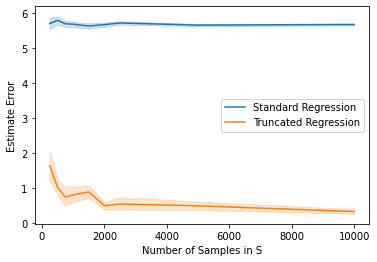

In [34]:
ax =sns.lineplot(data=ols_logs, x='num_samples', y='ols_epsilon', label='Standard Regression')
ax = sns.lineplot(data=unknown_logs, x='num_samples', y='unknown_epsilon', label='Truncated Regression')
ax.set(xlabel='Number of Samples in S', ylabel='Estimate Error')

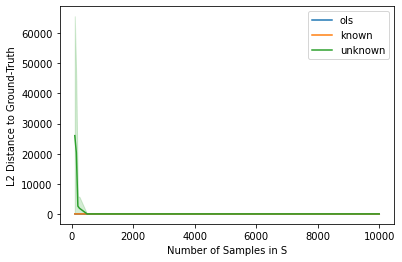

[Text(0.5, 0, 'Number of Samples in S'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

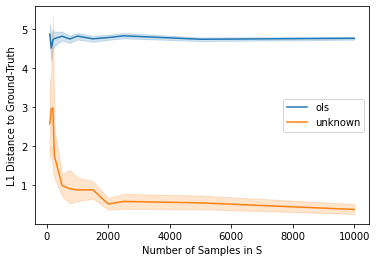

In [23]:
sns.lineplot(data=logs, x='num_samples', y='ols_param_mse', label='ols')
# sns.lineplot(data=logs, x='noise_scale', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=logs, x='num_samples', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Number of Samples in S', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='num_samples', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Number of Samples in S', ylabel='L1 Distance to Ground-Truth')

In [128]:
(scaled_kinterval(stand_y_trunc) != 1).nonzero(as_tuple=False)

tensor([], size=(0, 2), dtype=torch.int64)

In [142]:
ols_var

tensor([[6.6700]])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

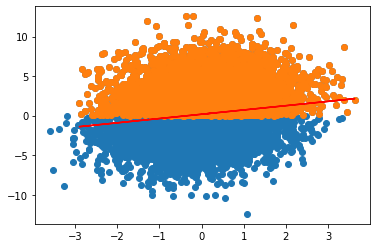

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])